# Analisis exploratorio de datos

En primer lugar, previo a la busqueda de anomalias, se realiza un EDA del dataset.

In [ ]:
#pip install pyarrow

In [1]:
##Se importan packages necesarios
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from pyspark.sql.types import StringType,TimestampType
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [2]:
#inicio de sesion en spark
ss_name = 'Lectura de datos Dashboard'
wg_conn = "spark.kerberos.access.hadoopFileSystems"
db_conn = "abfs://data@datalakesii.dfs.core.windows.net/"

spark = SparkSession.builder \
      .appName(f"Ejecucion algoritmo {ss_name}")  \
      .config(wg_conn, db_conn) \
      .config("spark.executor.memory", "6g") \
      .config("spark.driver.memory", "12g")\
      .config("spark.executor.cores", "4") \
      .config("spark.executor.instances", "5") \
      .config("spark.driver.maxResultSize", "12g") \
      .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

spark.conf.set("spark.sql.parquet.enableVectorizedReader","false")
spark.conf.set("spark.sql.parquet.int96RebaseModeInRead", "CORRECTED")
spark.conf.set("spark.sql.parquet.int96RebaseModeInWrite", "CORRECTED")
spark.conf.set("spark.sql.parquet.datetimeRebaseModeInRead", "CORRECTED")
spark.conf.set("spark.sql.parquet.datetimeRebaseModeInWrite", "CORRECTED")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Setting spark.hadoop.yarn.resourcemanager.principal to hvega.externo


In [3]:
ruta = "abfs://data@datalakesii.dfs.core.windows.net/DatosOrigen/lr-629/APA/Analisis_factura/dataset_final_no_estratificado"

# Leer el DataFrame desde la ruta especificada
dte = spark.read.format("parquet").load(ruta)

In [4]:
dte=dte.toPandas()

In [5]:
dte.columns

Index(['dhdr_mnt_total', 'dhdr_iva', 'recep_COCO_IMP_VENTAS_IVA',
       'recep_COCO_IMP_VENTAS_TRANSPORTE', 'recep_COCO_MTO_DEV_SOLICITADA_F22',
       'recep_COCO_MTO_VENTAS', 'recep_NEGO_NRO_FACTURAS_6MESES_VO',
       'emis_COCO_IMP_VENTAS_IVA', 'emis_COCO_IMP_VENTAS_TRANSPORTE',
       'emis_COCO_MTO_DEV_SOLICITADA_F22', 'emis_COCO_MTO_VENTAS',
       'emis_NEGO_NRO_FACTURAS_6MESES_VO', 'avg_dhdr_mnt_total_emisor',
       'stddev_dhdr_mnt_total_emisor', 'avg_dhdr_iva_emisor',
       'stddev_dhdr_iva_emisor', 'avg_dhdr_mnt_total_receptor',
       'stddev_dhdr_mnt_total_receptor', 'avg_dhdr_iva_receptor',
       'stddev_dhdr_iva_receptor', 'emis_CONT_RUT', 'emis_CONT_DV',
       'recep_CONT_RUT', 'recep_CONT_DV', 'es_fin_de_semana', 'bloque_horario',
       'dia_semana', 'semana_mes', 'emis_INICIO_SEGMENTO',
       'emis_ACEC_DES_SUBRUBRO_PPAL', 'emis_Alerta_1019', 'emis_Alerta_2250',
       'emis_Alerta_400X', 'emis_Alerta_4110', 'emis_Alerta_4111',
       'emis_Alerta_4112', 'emis

In [6]:
spark.stop()

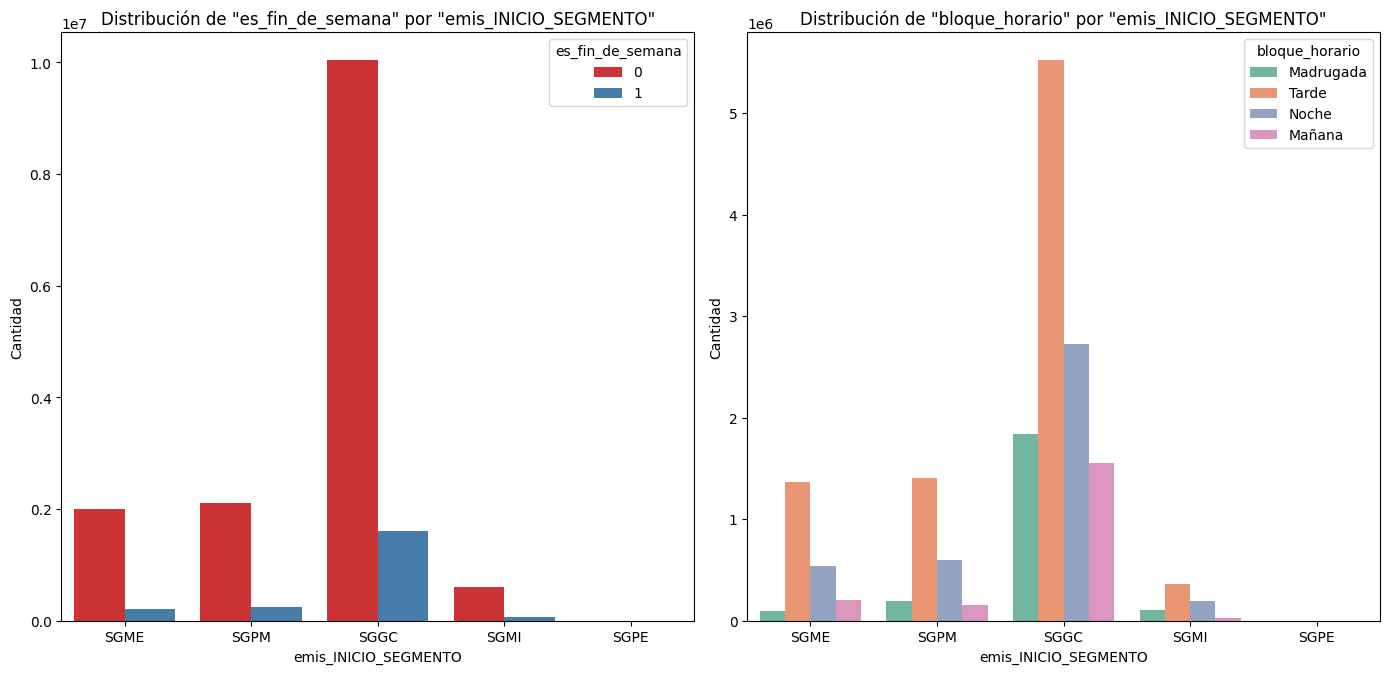

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el tamaño de la figura
plt.figure(figsize=(14, 7))

# Crear un gráfico de barras para 'es_fin_de_semana' vs 'emis_INICIO_SEGMENTO'
plt.subplot(1, 2, 1)  # Subgráfico 1
sns.countplot(x='emis_INICIO_SEGMENTO', hue='es_fin_de_semana', data=dte, palette='Set1')
plt.title('Distribución de "es_fin_de_semana" por "emis_INICIO_SEGMENTO"')
plt.xlabel('emis_INICIO_SEGMENTO')
plt.ylabel('Cantidad')

# Crear un gráfico de barras para 'bloque_horario' vs 'emis_INICIO_SEGMENTO'
plt.subplot(1, 2, 2)  # Subgráfico 2
sns.countplot(x='emis_INICIO_SEGMENTO', hue='bloque_horario', data=dte, palette='Set2')
plt.title('Distribución de "bloque_horario" por "emis_INICIO_SEGMENTO"')
plt.xlabel('emis_INICIO_SEGMENTO')
plt.ylabel('Cantidad')

# Ajustar el espacio entre los subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()


En este grafico claramente se observa que el grupo de grandes contribuyentes es el que mas emite. Los mayores montos se emiten durante dia de semana habil, como es esperable. Por otro lado, los mayores montos son emitidos durante la tarde.

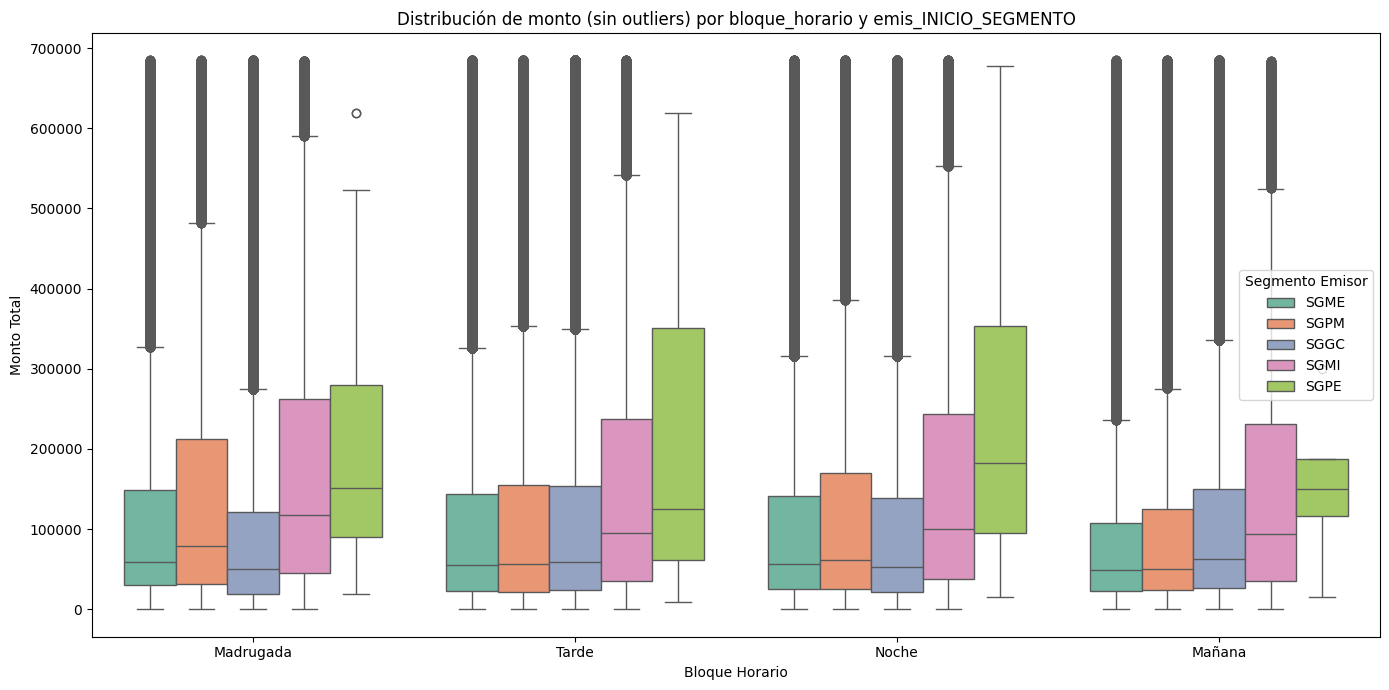

In [8]:
import pandas as pd

# Asegurarse de que 'dhdr_mnt_total' está en formato float
dte['dhdr_mnt_total'] = dte['dhdr_mnt_total'].astype(float)

# Calcular el rango intercuartílico (IQR) para 'dhdr_mnt_total'
Q1 = dte['dhdr_mnt_total'].quantile(0.25)
Q3 = dte['dhdr_mnt_total'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites superior e inferior para los valores no atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers
dte_filtered = dte[(dte['dhdr_mnt_total'] >= lower_bound) & (dte['dhdr_mnt_total'] <= upper_bound)]

# Crear el gráfico sin los outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.boxplot(x='bloque_horario', y='dhdr_mnt_total', hue='emis_INICIO_SEGMENTO', data=dte_filtered, palette='Set2')

# Ajustar el título y etiquetas
plt.title('Distribución de monto (sin outliers) por bloque_horario y emis_INICIO_SEGMENTO')
plt.xlabel('Bloque Horario')
plt.ylabel('Monto Total')

# Mostrar la leyenda y los gráficos
plt.legend(title='Segmento Emisor')
plt.tight_layout()
plt.show()


Sacando los outlier sy observando la distribucion del monto emitido para cada segmento emisor, por bloque horario, se observa que los emisores de tipo persona natural tienen en general mayores montos que los otros segmentos. 

In [9]:
import pandas as pd

# Definir las columnas de alertas para emisor y receptor
alertas_emisor = [
    'emis_Alerta_1019', 'emis_Alerta_2250', 'emis_Alerta_400X', 'emis_Alerta_4110',
    'emis_Alerta_4111', 'emis_Alerta_4112', 'emis_Alerta_4113', 'emis_Alerta_52',
    'emis_Alerta_5201', 'emis_Alerta_5203', 'emis_Alerta_53', 'emis_Alerta_5301'
]

alertas_receptor = [
    'recep_Alerta_1019', 'recep_Alerta_2250', 'recep_Alerta_400X', 'recep_Alerta_4110',
    'recep_Alerta_4111', 'recep_Alerta_4112', 'recep_Alerta_4113', 'recep_Alerta_52',
    'recep_Alerta_5201', 'recep_Alerta_5203', 'recep_Alerta_53', 'recep_Alerta_5301'
]

# Crear una columna que indique si hay alguna alerta en el emisor
dte['alertas_emisor'] = dte[alertas_emisor].any(axis=1)

# Crear una columna que indique si hay alguna alerta en el receptor
dte['alertas_receptor'] = dte[alertas_receptor].any(axis=1)

# Crear una columna que indique si ambos, emisor y receptor, tienen alertas
dte['alertas_combinadas'] = dte['alertas_emisor'] & dte['alertas_receptor']

# Ahora contamos cuántas transacciones por segmento y bloque horario tienen alertas combinadas
count_alertas = dte.groupby(['emis_INICIO_SEGMENTO', 'bloque_horario'])['alertas_combinadas'].sum().reset_index()

# Ordenar el resultado de mayor a menor según el recuento de alertas combinadas
count_alertas_sorted = count_alertas.sort_values(by='alertas_combinadas', ascending=False)

# Mostrar el recuento ordenado
print(count_alertas_sorted)


   emis_INICIO_SEGMENTO bloque_horario  alertas_combinadas
3                  SGGC          Tarde               82402
2                  SGGC          Noche               43322
1                  SGGC         Mañana               22754
0                  SGGC      Madrugada               22487
7                  SGME          Tarde               18425
19                 SGPM          Tarde               15495
18                 SGPM          Noche                7502
6                  SGME          Noche                7065
11                 SGMI          Tarde                4386
16                 SGPM      Madrugada                2949
10                 SGMI          Noche                2335
4                  SGME      Madrugada                2330
5                  SGME         Mañana                2159
8                  SGMI      Madrugada                1425
17                 SGPM         Mañana                1398
9                  SGMI         Mañana                 2

En esta tabla, se posible observar cuales son los bloques horarios y segmentos que tienen mayores transacciones en las cuales tanto emisor como receptor tiene alertas tributarias. El segmento de grandes contribuyentes lidera esa lista.

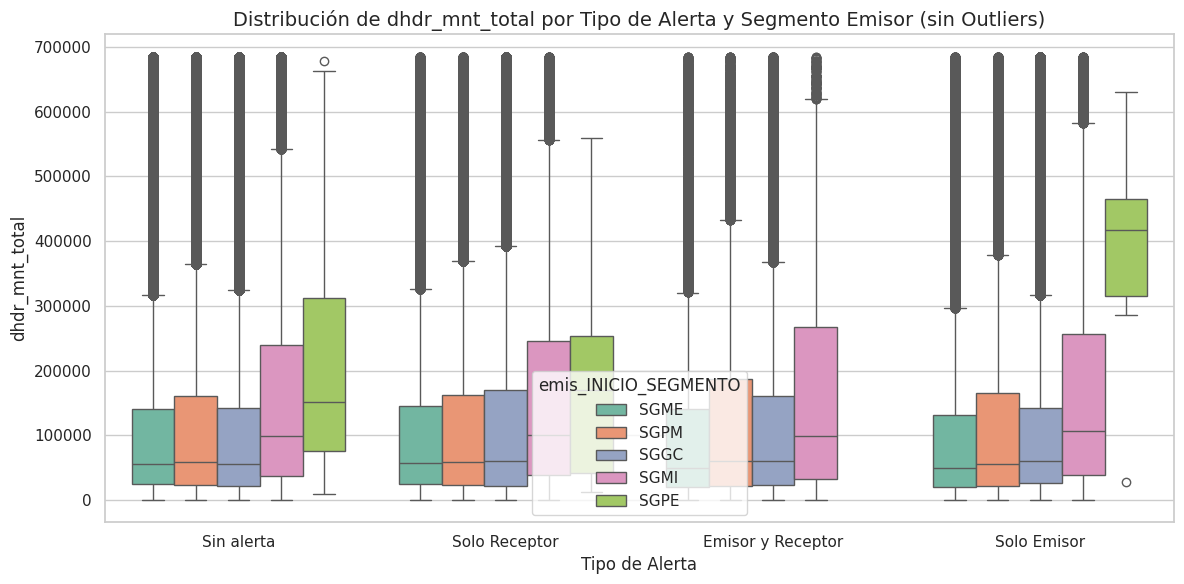

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular el rango intercuartílico (IQR) para 'dhdr_mnt_total'
Q1 = dte['dhdr_mnt_total'].quantile(0.25)
Q3 = dte['dhdr_mnt_total'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para identificar los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar las filas donde 'dhdr_mnt_total' está dentro de los límites
dte_no_outliers = dte[(dte['dhdr_mnt_total'] >= lower_bound) & (dte['dhdr_mnt_total'] <= upper_bound)]

# Filtrar las transacciones según el tipo de alerta
df_alertas = dte_no_outliers.copy()

# Alerta combinada (emisor y receptor tienen alertas)
df_alertas['alertas_combinadas'] = df_alertas['alertas_emisor'] & df_alertas['alertas_receptor']

# Solo emisor tiene alerta
df_alertas['solo_emisor'] = df_alertas['alertas_emisor'] & ~df_alertas['alertas_receptor']

# Solo receptor tiene alerta
df_alertas['solo_receptor'] = ~df_alertas['alertas_emisor'] & df_alertas['alertas_receptor']

# Crear una nueva columna que combine las alertas
df_alertas['tipo_alerta'] = 'Sin alerta'
df_alertas.loc[df_alertas['alertas_combinadas'], 'tipo_alerta'] = 'Emisor y Receptor'
df_alertas.loc[df_alertas['solo_emisor'], 'tipo_alerta'] = 'Solo Emisor'
df_alertas.loc[df_alertas['solo_receptor'], 'tipo_alerta'] = 'Solo Receptor'

# Ahora creamos el boxplot sin los outliers y con división por 'emis_INICIO_SEGMENTO'
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Graficar el boxplot con división por 'emis_INICIO_SEGMENTO'
sns.boxplot(x='tipo_alerta', y='dhdr_mnt_total', data=df_alertas, hue='emis_INICIO_SEGMENTO', palette='Set2')

# Añadir título y etiquetas
plt.title('Distribución de dhdr_mnt_total por Tipo de Alerta y Segmento Emisor (sin Outliers)', fontsize=14)
plt.xlabel('Tipo de Alerta', fontsize=12)
plt.ylabel('dhdr_mnt_total', fontsize=12)

# Ajustar presentación
plt.tight_layout()

# Mostrar el gráfico
plt.show()


En este grafico podemos ver que los montos son sensiblemente mayores en distribucion cuando el emisor tiene alerta y es de tipo SGPE.

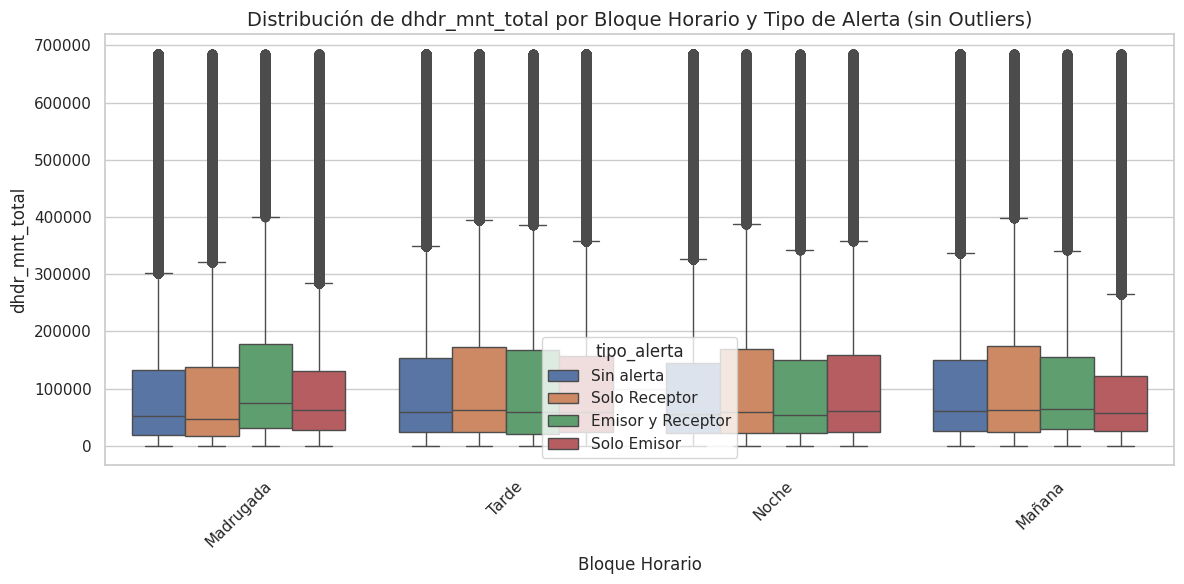

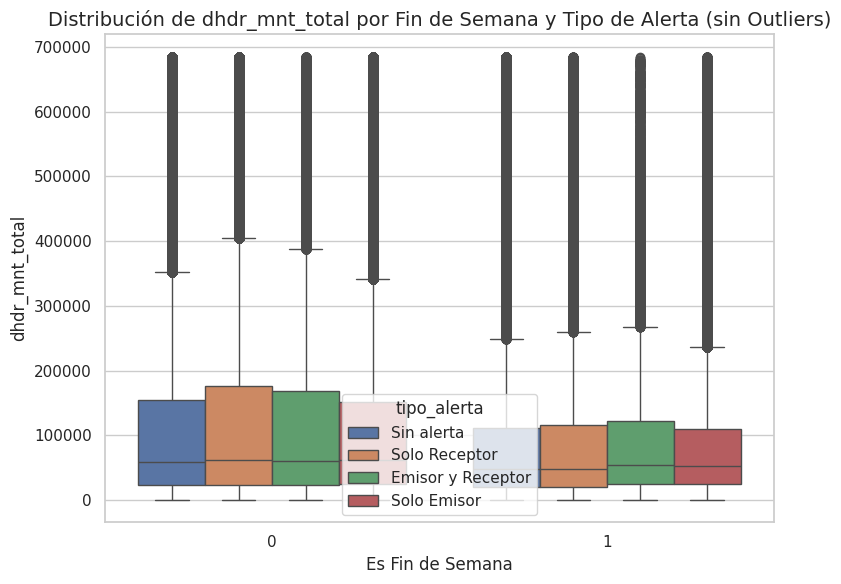

In [11]:

# Calcular el rango intercuartílico (IQR) para 'dhdr_mnt_total'
Q1 = dte['dhdr_mnt_total'].quantile(0.25)
Q3 = dte['dhdr_mnt_total'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para identificar los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar las filas donde 'dhdr_mnt_total' está dentro de los límites
dte_no_outliers = dte[(dte['dhdr_mnt_total'] >= lower_bound) & (dte['dhdr_mnt_total'] <= upper_bound)]

# Filtrar las transacciones según el tipo de alerta
df_alertas = dte_no_outliers.copy()

# Convertir las columnas de alerta a booleanos (True/False)
alertas_emisor = [
    'emis_Alerta_1019', 'emis_Alerta_2250', 'emis_Alerta_400X', 'emis_Alerta_4110',
    'emis_Alerta_4111', 'emis_Alerta_4112', 'emis_Alerta_4113', 'emis_Alerta_52',
    'emis_Alerta_5201', 'emis_Alerta_5203', 'emis_Alerta_53', 'emis_Alerta_5301'
]
alertas_receptor = [
    'recep_Alerta_1019', 'recep_Alerta_2250', 'recep_Alerta_400X', 'recep_Alerta_4110',
    'recep_Alerta_4111', 'recep_Alerta_4112', 'recep_Alerta_4113', 'recep_Alerta_52',
    'recep_Alerta_5201', 'recep_Alerta_5203', 'recep_Alerta_53', 'recep_Alerta_5301'
]

# Asegurarse de que las columnas de alerta son booleanas (True/False), llenando NaN con False
for col in alertas_emisor + alertas_receptor:
    df_alertas[col] = df_alertas[col].fillna(False).astype(bool)

# Alerta combinada (emisor y receptor tienen alertas)
df_alertas['alertas_combinadas'] = df_alertas[alertas_emisor].any(axis=1) & df_alertas[alertas_receptor].any(axis=1)

# Solo emisor tiene alerta
df_alertas['solo_emisor'] = df_alertas[alertas_emisor].any(axis=1) & ~df_alertas[alertas_receptor].any(axis=1)

# Solo receptor tiene alerta
df_alertas['solo_receptor'] = ~df_alertas[alertas_emisor].any(axis=1) & df_alertas[alertas_receptor].any(axis=1)

# Clasificar según las alertas
df_alertas['tipo_alerta'] = 'Sin alerta'
df_alertas.loc[df_alertas['alertas_combinadas'], 'tipo_alerta'] = 'Emisor y Receptor'
df_alertas.loc[df_alertas['solo_emisor'], 'tipo_alerta'] = 'Solo Emisor'
df_alertas.loc[df_alertas['solo_receptor'], 'tipo_alerta'] = 'Solo Receptor'

# Graficar el boxplot por bloque horario
plt.figure(figsize=(12, 6))
sns.boxplot(x='bloque_horario', y='dhdr_mnt_total', data=df_alertas, hue='tipo_alerta')

plt.title('Distribución de dhdr_mnt_total por Bloque Horario y Tipo de Alerta (sin Outliers)', fontsize=14)
plt.xlabel('Bloque Horario', fontsize=12)
plt.ylabel('dhdr_mnt_total', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graficar el boxplot por si es fin de semana
plt.figure(figsize=(8, 6))
sns.boxplot(x='es_fin_de_semana', y='dhdr_mnt_total', data=df_alertas, hue='tipo_alerta')

plt.title('Distribución de dhdr_mnt_total por Fin de Semana y Tipo de Alerta (sin Outliers)', fontsize=14)
plt.xlabel('Es Fin de Semana', fontsize=12)
plt.ylabel('dhdr_mnt_total', fontsize=12)
plt.tight_layout()
plt.show()


En cuanto al monto de alerta por bloque horario o si es fin de semana o no, no pareciera influir.

/tmp/ipykernel_779/3610079831.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_779/3610079831.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


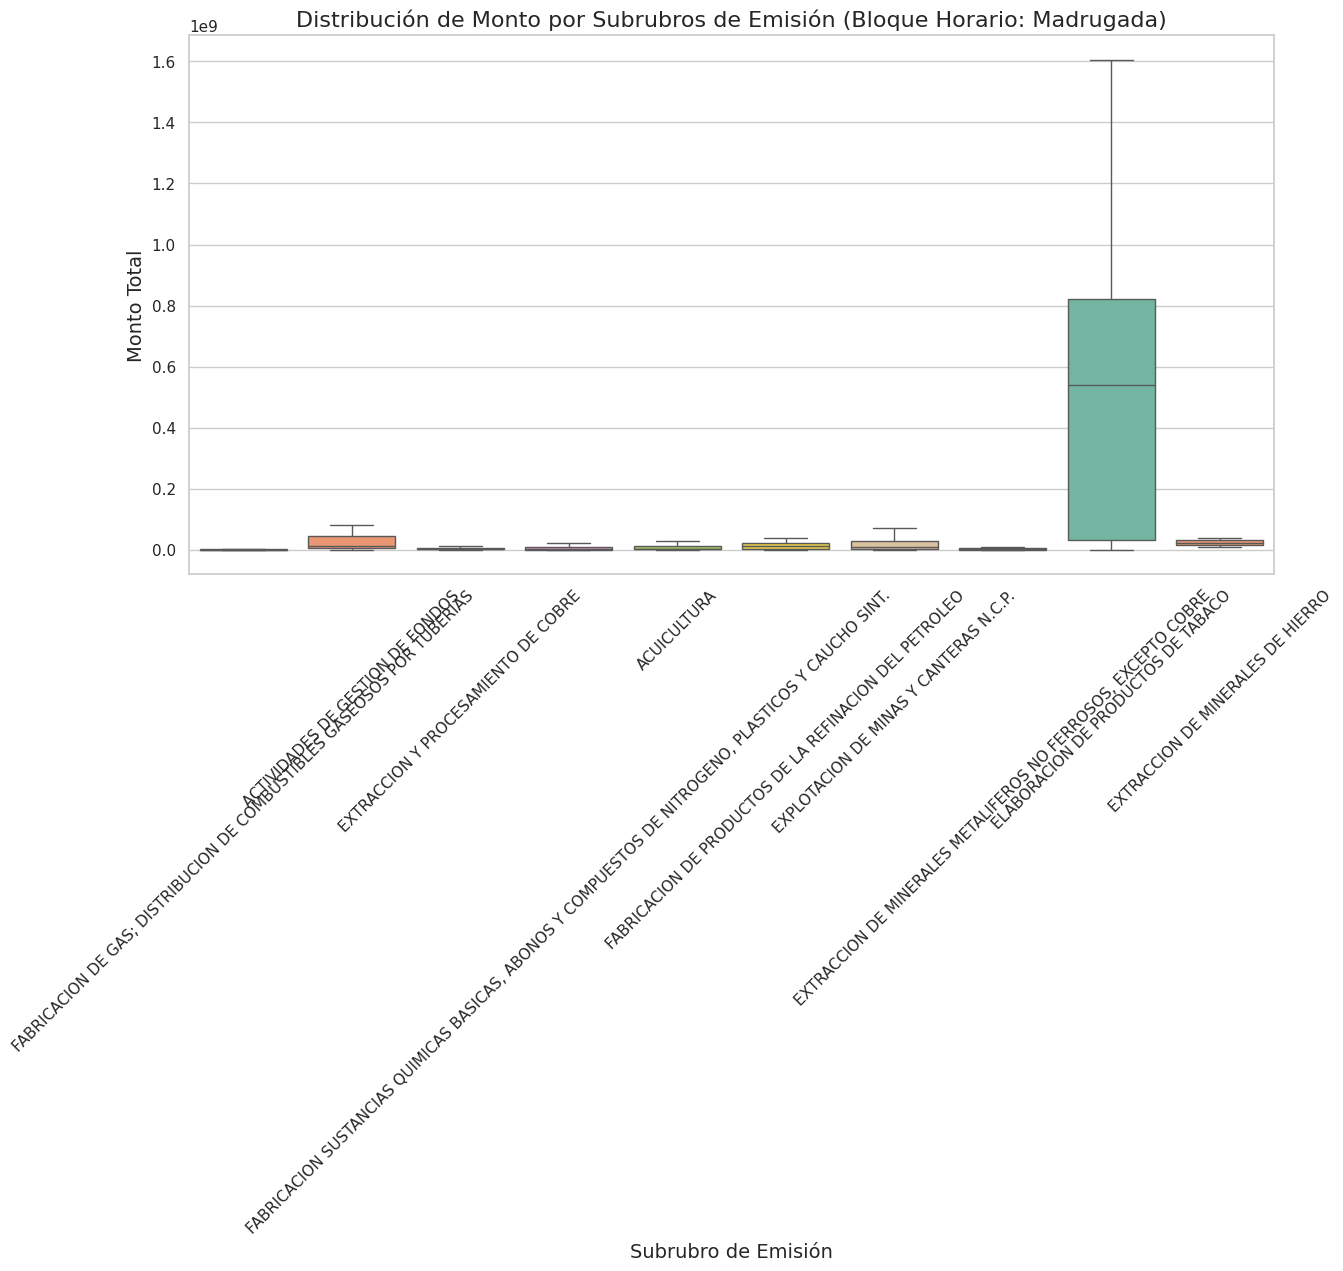

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarse de que 'dhdr_mnt_total' está en formato float
dte['dhdr_mnt_total'] = dte['dhdr_mnt_total'].astype(float)

# Filtrar los datos donde el bloque horario sea "Madrugada"
dte_madrugada = dte[dte['bloque_horario'] == 'Madrugada']

# Calcular el monto promedio por subrubro de emisión
monto_promedio_por_subrubro = dte_madrugada.groupby('emis_ACEC_DES_SUBRUBRO_PPAL')['dhdr_mnt_total'].mean().sort_values(ascending=False)

# Seleccionar los 10 subrubros con el mayor monto promedio
subrubros_top = monto_promedio_por_subrubro.head(10).index

# Filtrar el DataFrame para solo incluir estos subrubros
dte_madrugada_top = dte_madrugada[dte_madrugada['emis_ACEC_DES_SUBRUBRO_PPAL'].isin(subrubros_top)]

# Graficar la distribución de monto por subrubros de emisión para el bloque "Madrugada"
plt.figure(figsize=(14, 7))

sns.boxplot(
    x='emis_ACEC_DES_SUBRUBRO_PPAL', 
    y='dhdr_mnt_total', 
    data=dte_madrugada_top,
    palette='Set2',  # Paleta de colores
    showfliers=False  # No mostrar los outliers
)

# Ajustar el título y las etiquetas
plt.title('Distribución de Monto por Subrubros de Emisión (Bloque Horario: Madrugada)', fontsize=16)
plt.xlabel('Subrubro de Emisión', fontsize=14)
plt.ylabel('Monto Total', fontsize=14)

# Ajustar la presentación
plt.xticks(rotation=45)  # Rotar las etiquetas de los subrubros si es necesario
plt.tight_layout()

# Mostrar el gráfico
plt.show()


En este caso, filtrando para fin de semana y bloque horario madrugada, se observa que el rubro de emision Extraccion de minerales metaliferos no ferrosos presenta una distribucion de montos mayor al de otros rubros.

      bloque_horario                 recep_ACEC_DES_SUBRUBRO_PPAL  \
2579       Madrugada          EXTRACCION Y PROCESAMIENTO DE COBRE   
8516       Madrugada  FABRICACION DE PRODUCTOS DE HORNOS DE COQUE   
8522       Madrugada  FABRICACION DE PRODUCTOS DE HORNOS DE COQUE   
15549      Madrugada          EXTRACCION Y PROCESAMIENTO DE COBRE   
35106      Madrugada          EXTRACCION Y PROCESAMIENTO DE COBRE   

       dhdr_mnt_total  
2579          13646.0  
8516        3593300.0  
8522          58900.0  
15549       1360000.0  
35106         30000.0  


/tmp/ipykernel_779/1620082069.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


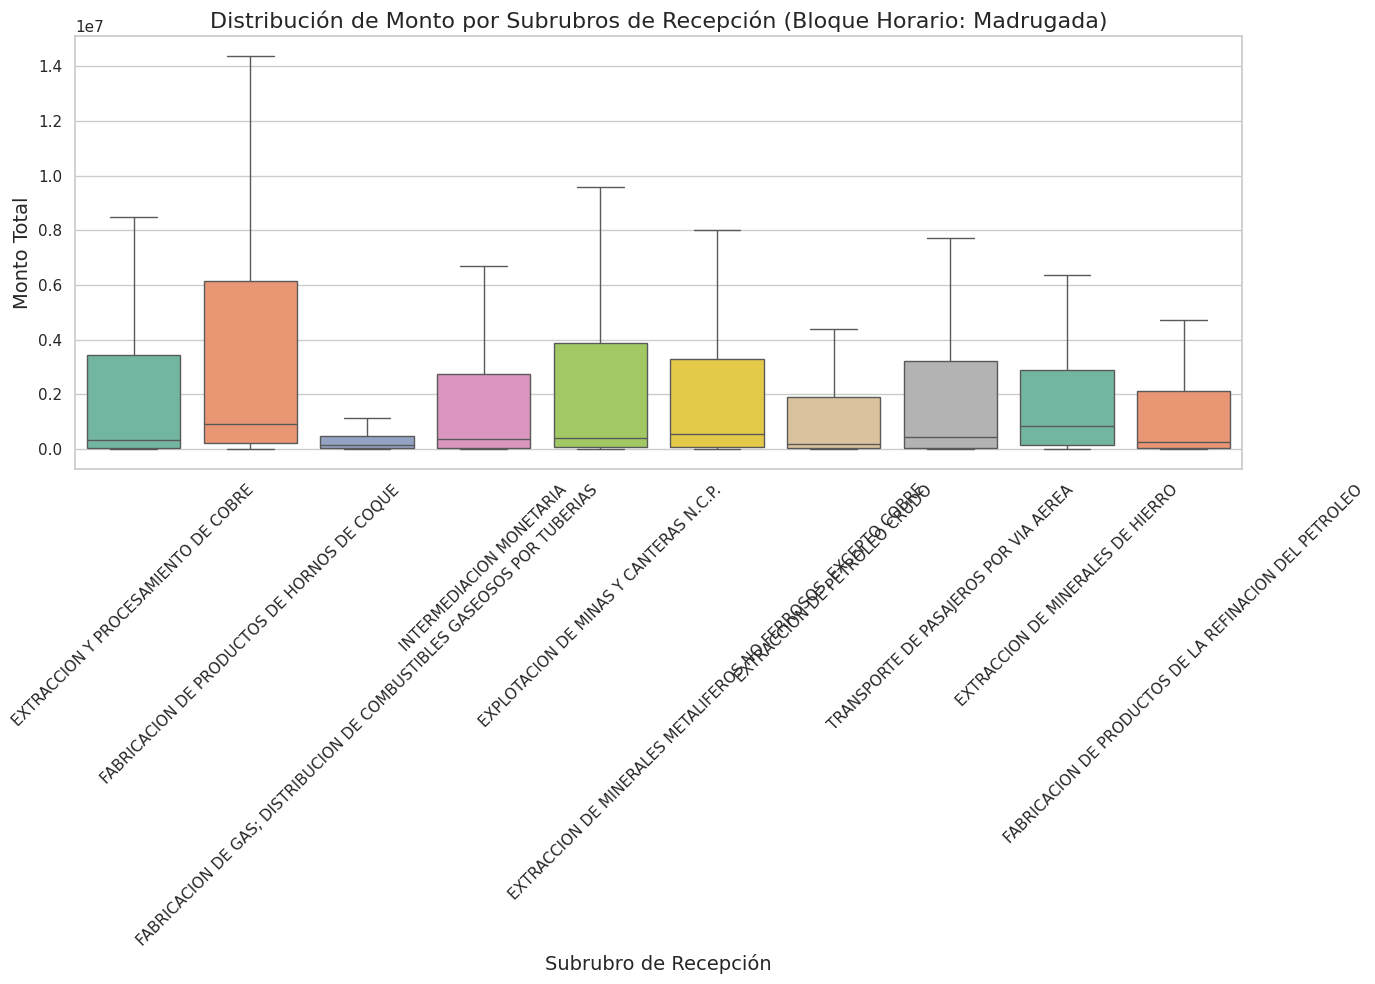

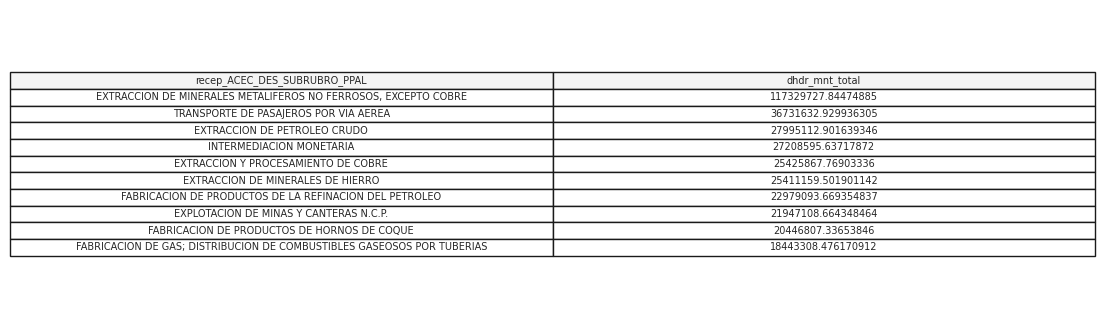

In [17]:

# Asegurarse de que 'dhdr_mnt_total' está en formato float
dte['dhdr_mnt_total'] = dte['dhdr_mnt_total'].astype(float)

# Filtrar los datos donde el bloque horario sea "Madrugada"
dte_madrugada = dte[dte['bloque_horario'] == 'Madrugada']

# Calcular el monto promedio por subrubro de recepción
monto_promedio_por_subrubro = dte_madrugada.groupby('recep_ACEC_DES_SUBRUBRO_PPAL')['dhdr_mnt_total'].mean().sort_values(ascending=False)

# Seleccionar los 10 subrubros con el mayor monto promedio
subrubros_top = monto_promedio_por_subrubro.head(10).index

# Filtrar el DataFrame para solo incluir estos subrubros
dte_madrugada_top = dte_madrugada[dte_madrugada['recep_ACEC_DES_SUBRUBRO_PPAL'].isin(subrubros_top)]

# Verificar los primeros registros para asegurarse del filtro
print(dte_madrugada_top[['bloque_horario', 'recep_ACEC_DES_SUBRUBRO_PPAL', 'dhdr_mnt_total']].head())

# Graficar la distribución de monto por subrubros de recepción para el bloque "Madrugada"
plt.figure(figsize=(14, 10))

# Gráfico de caja
sns.boxplot(
    x='recep_ACEC_DES_SUBRUBRO_PPAL', 
    y='dhdr_mnt_total', 
    data=dte_madrugada_top,
    palette='Set2',  # Paleta de colores
    showfliers=False  # No mostrar los outliers
)

# Ajustar el título y las etiquetas
plt.title('Distribución de Monto por Subrubros de Recepción (Bloque Horario: Madrugada)', fontsize=16)
plt.xlabel('Subrubro de Recepción', fontsize=14)
plt.ylabel('Monto Total', fontsize=14)

# Ajustar la presentación
plt.xticks(rotation=45)  # Rotar las etiquetas de los subrubros si es necesario
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Mostrar la tabla con los valores promedio por subrubro de recepción
tabla_promedio = monto_promedio_por_subrubro.head(10).reset_index()

# Mostrar la tabla debajo del gráfico
fig, ax = plt.subplots(figsize=(14, 4))  # Crear una nueva figura para la tabla
ax.axis('tight')
ax.axis('off')
ax.table(cellText=tabla_promedio.values, colLabels=tabla_promedio.columns, cellLoc='center', loc='center', colColours=["#f5f5f5"]*len(tabla_promedio.columns))

plt.show()


En cuanto al rubro que mas recibe en el bloque horario de madrugada, el rubro Extraccion de minerales metaliferos no ferrosos sigue liderando ese monto. 

                           emis_ACEC_DES_SUBRUBRO_PPAL  dhdr_mnt_total
89   VENTA AL POR MAYOR DE ALIMENTOS, BEBIDAS Y TABACO    6.187994e+09
6    ACTIVIDADES DE APOYO A LA AGRICULTURA Y LA GAN...    4.614636e+09
19   ACTIVIDADES DE SERVICIOS DE APOYO A LAS EMPRES...    3.966926e+09
72   OTRAS ACTIVIDADES DE VENTA AL POR MAYOR ESPECI...    3.248528e+09
88   VENTA AL POR MAYOR A CAMBIO DE UNA RETRIBUCION...    2.870524e+09
68    OTRAS ACTIVIDADES DE ESPARCIMIENTO Y RECREATIVAS    2.599513e+09
101  VENTA AL POR MENOR NO REALIZADA EN COMERCIOS, ...    1.980885e+09
0    ACTIVIDADES ADMINISTRATIVAS Y DE APOYO DE OFICINA    1.794266e+09
73    OTRAS ACTIVIDADES ESPECIALIZADAS DE CONSTRUCCION    1.737957e+09
64   INSTALACIONES ELECTRICAS, DE GASFITERIA Y OTRA...    1.299140e+09


/tmp/ipykernel_779/3073559320.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dhdr_mnt_total', y='emis_ACEC_DES_SUBRUBRO_PPAL', data=monto_subrubro_alertas_sorted.head(10), palette='viridis')


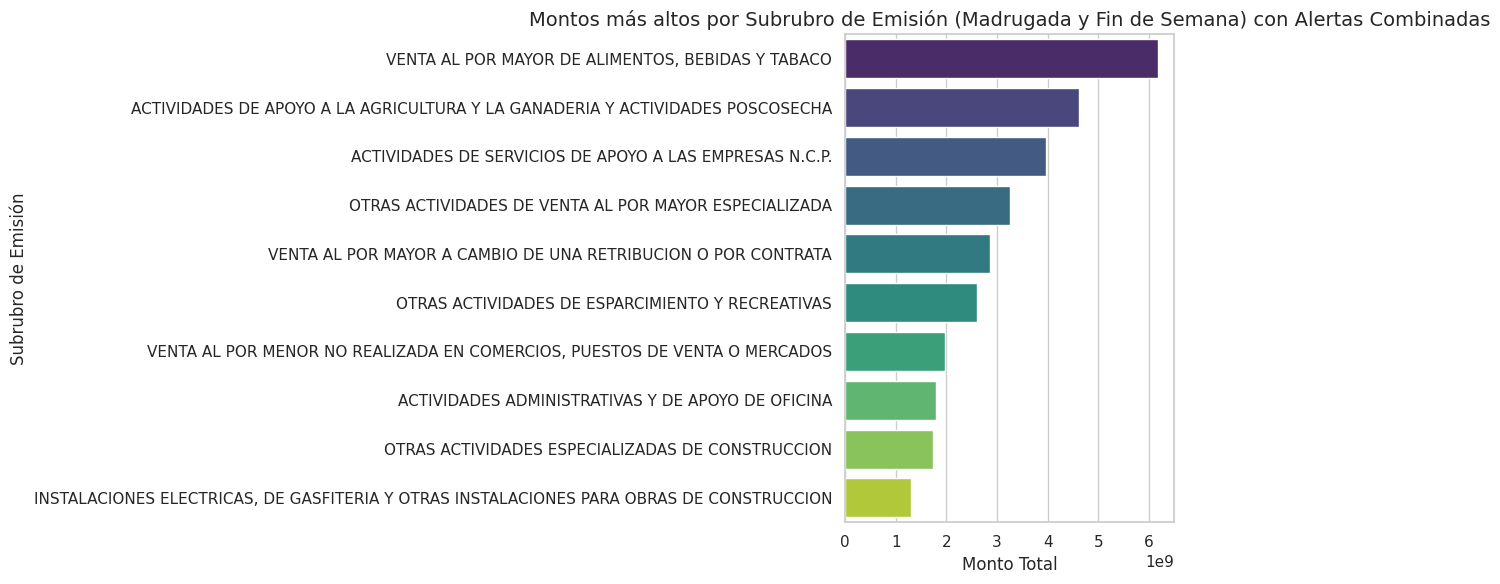

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para el bloque horario 'Madrugada' y 'Fin de semana'
dte_madrugada_finde = dte[(dte['bloque_horario'] == 'Madrugada') & (dte['es_fin_de_semana'] == True)]

# Filtrar solo los registros donde tanto el emisor como el receptor tienen alertas
dte_alertas_combinadas = dte_madrugada_finde[dte_madrugada_finde['alertas_combinadas']]

# Agrupar por subrubro de emisor y calcular el monto total promedio
monto_subrubro_alertas = dte_alertas_combinadas.groupby('emis_ACEC_DES_SUBRUBRO_PPAL')['dhdr_mnt_total'].sum().reset_index()

# Ordenar de mayor a menor según el monto total
monto_subrubro_alertas_sorted = monto_subrubro_alertas.sort_values(by='dhdr_mnt_total', ascending=False)

# Mostrar los primeros 10 resultados (los montos más altos)
print(monto_subrubro_alertas_sorted.head(10))

# Opcional: Graficar los 10 subrubros con más monto
plt.figure(figsize=(12, 6))
sns.barplot(x='dhdr_mnt_total', y='emis_ACEC_DES_SUBRUBRO_PPAL', data=monto_subrubro_alertas_sorted.head(10), palette='viridis')

plt.title('Montos más altos por Subrubro de Emisión (Madrugada y Fin de Semana) con Alertas Combinadas', fontsize=14)
plt.xlabel('Monto Total', fontsize=12)
plt.ylabel('Subrubro de Emisión', fontsize=12)

plt.tight_layout()
plt.show()


En este grafico información sobre los montos totales relacionados con alertas combinadas durante el bloque horario de "Madrugada" y "Fin de Semana". EN particular muestra los rubros donde tanto el emisor como el receptor tienen alertas, ordenados por emision de mayor a menor. 

### Busqueda de reglas de anomalias
Para tener una lnea clara, lo que haremos es tomar los datos que se alejan del rango intercuartil en cuanto monto para cada subrubro emisor. De esta forma, nos enfocaremos en el segmento y sus montos, rubor emisor, bloque horario, si es fin de semana y si el emisor presenta o no presenta alertas.

In [21]:
dte['emis_INICIO_SEGMENTO'].unique()

array(['SGME', 'SGPM', 'SGGC', 'SGMI', None, 'SGPE'], dtype=object)

In [28]:
# Crear un diccionario para almacenar el percentil 90 y el tamaño de los outliers por segmento
outliers_info_segmento = {}

for segmento in ['SGME', 'SGPM', 'SGGC', 'SGMI', 'SGPE']:
    # Filtrar las filas correspondientes a cada segmento
    dte_segmento = dte[dte['emis_INICIO_SEGMENTO'] == segmento]
    
    # Calcular el percentil 90 para el monto
    percentil_90 = dte_segmento['dhdr_mnt_total'].quantile(0.9)
    
    # Filtrar las filas con monto superior al percentil 90 (outliers)
    outliers_segmento = dte_segmento[dte_segmento['dhdr_mnt_total'] > percentil_90]
    
    # Almacenar el percentil 90 y el tamaño de los outliers
    outliers_info_segmento[segmento] = {
        'percentil_90': percentil_90,
        'tamaño_outliers': outliers_segmento.shape[0]
    }

# Mostrar la información del percentil 90 y tamaño de los outliers para cada segmento
for segmento, info in outliers_info_segmento.items():
    print(f"Segmento: {segmento}")
    print(f"Percentil 90 (Monto): {info['percentil_90']}")
    print(f"Tamaño de los Outliers: {info['tamaño_outliers']}")
    print("-" * 40)


Segmento: SGME
Percentil 90 (Monto): 1170000.0
Tamaño de los Outliers: 220531
----------------------------------------
Segmento: SGPM
Percentil 90 (Monto): 1760010.0
Tamaño de los Outliers: 235336
----------------------------------------
Segmento: SGGC
Percentil 90 (Monto): 1104695.4000000004
Tamaño de los Outliers: 1164345
----------------------------------------
Segmento: SGMI
Percentil 90 (Monto): 2070600.0
Tamaño de los Outliers: 68017
----------------------------------------
Segmento: SGPE
Percentil 90 (Monto): 3913102.000000001
Tamaño de los Outliers: 28
----------------------------------------


In [33]:
# Crear diccionarios para almacenar los datos con y sin alerta por segmento
alertas_por_segmento = {}
sin_alerta_por_segmento = {}

for segmento in ['SGME', 'SGPM', 'SGGC', 'SGMI', 'SGPE']:
    # Filtrar las filas correspondientes a cada segmento
    dte_segmento = dte[dte['emis_INICIO_SEGMENTO'] == segmento]
    
    # Calcular el percentil 90 para el monto
    percentil_90 = dte_segmento['dhdr_mnt_total'].quantile(0.9)
    
    # Filtrar las filas con monto superior al percentil 90 (outliers)
    outliers_segmento = dte_segmento[dte_segmento['dhdr_mnt_total'] > percentil_90]
    
    # Filtrar los datos con alerta
    outliers_alertas = outliers_segmento[outliers_segmento.filter(like='emis_Alerta_').any(axis=1)]
    
    # Filtrar los datos sin alerta
    outliers_sin_alerta = outliers_segmento[~outliers_segmento.filter(like='emis_Alerta_').any(axis=1)]
    
    # Guardar los resultados
    alertas_por_segmento[segmento] = outliers_alertas
    sin_alerta_por_segmento[segmento] = outliers_sin_alerta


/tmp/ipykernel_779/445903056.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


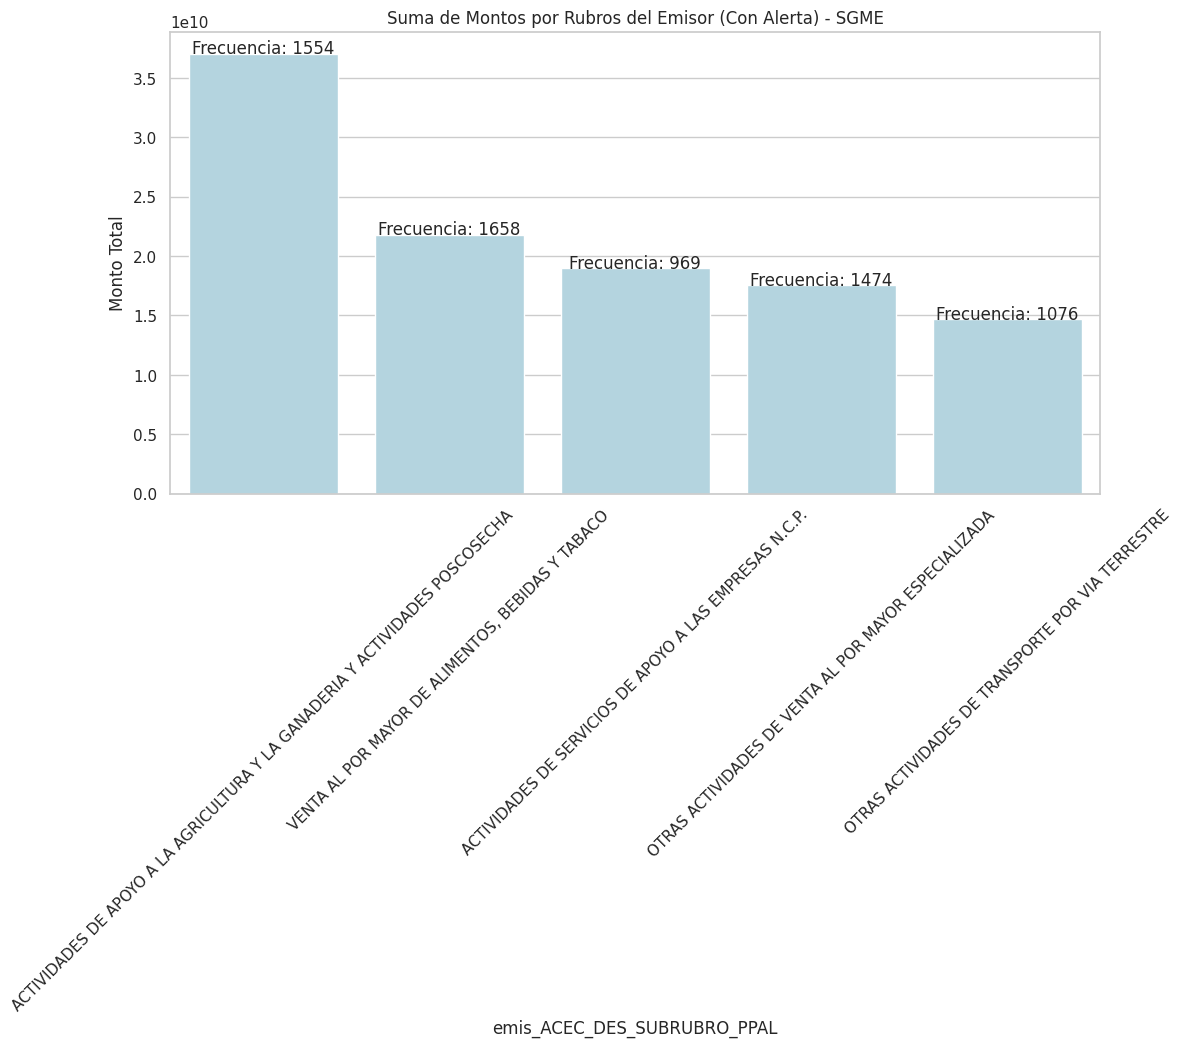

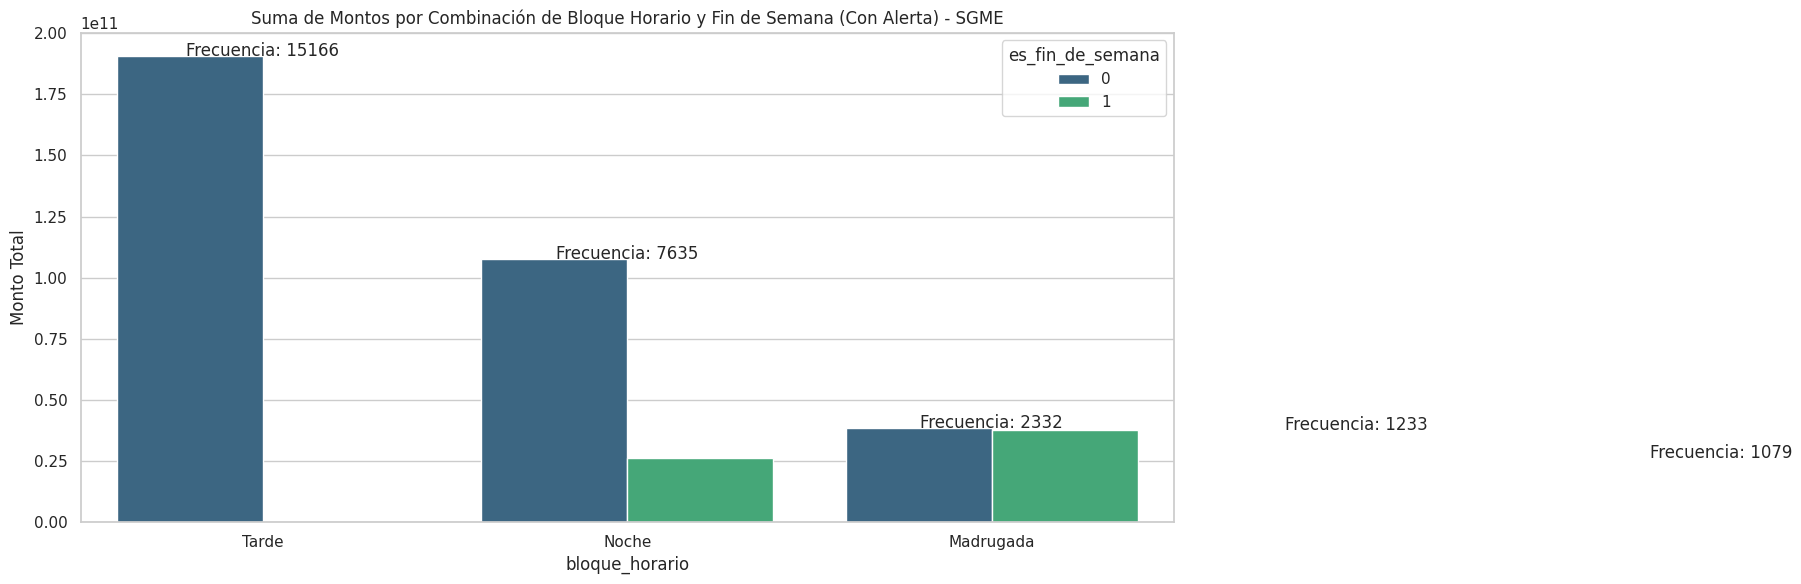

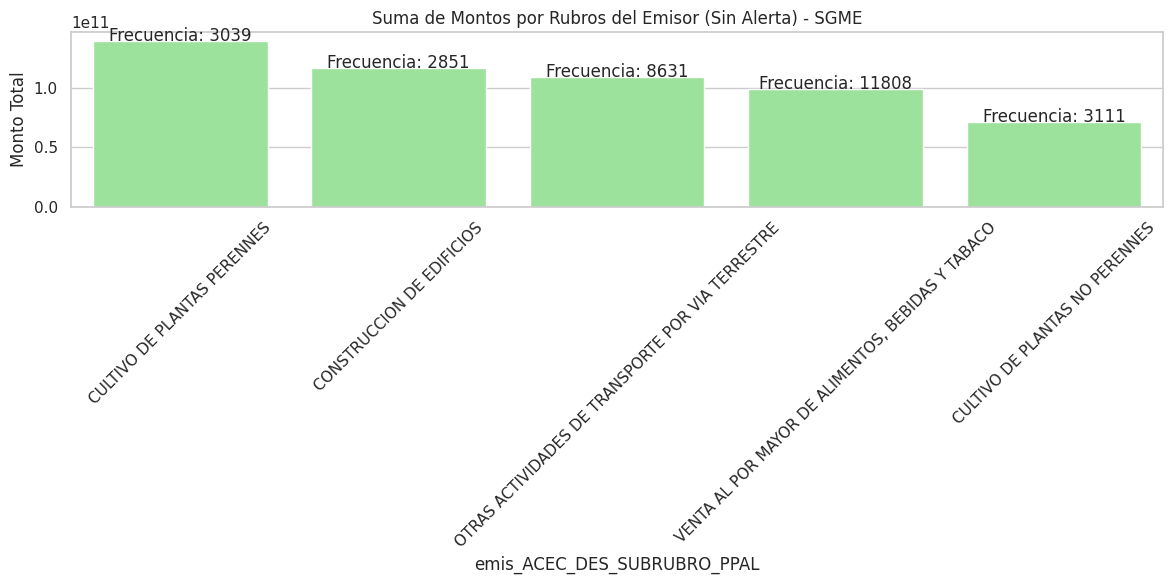

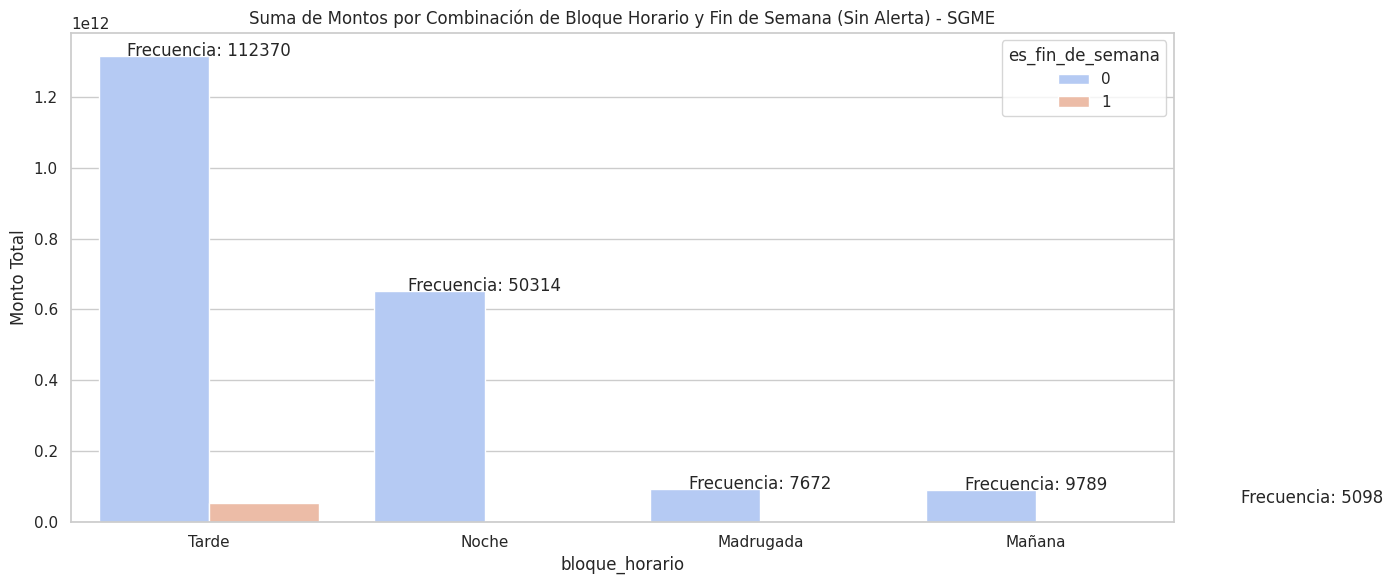

/tmp/ipykernel_779/445903056.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


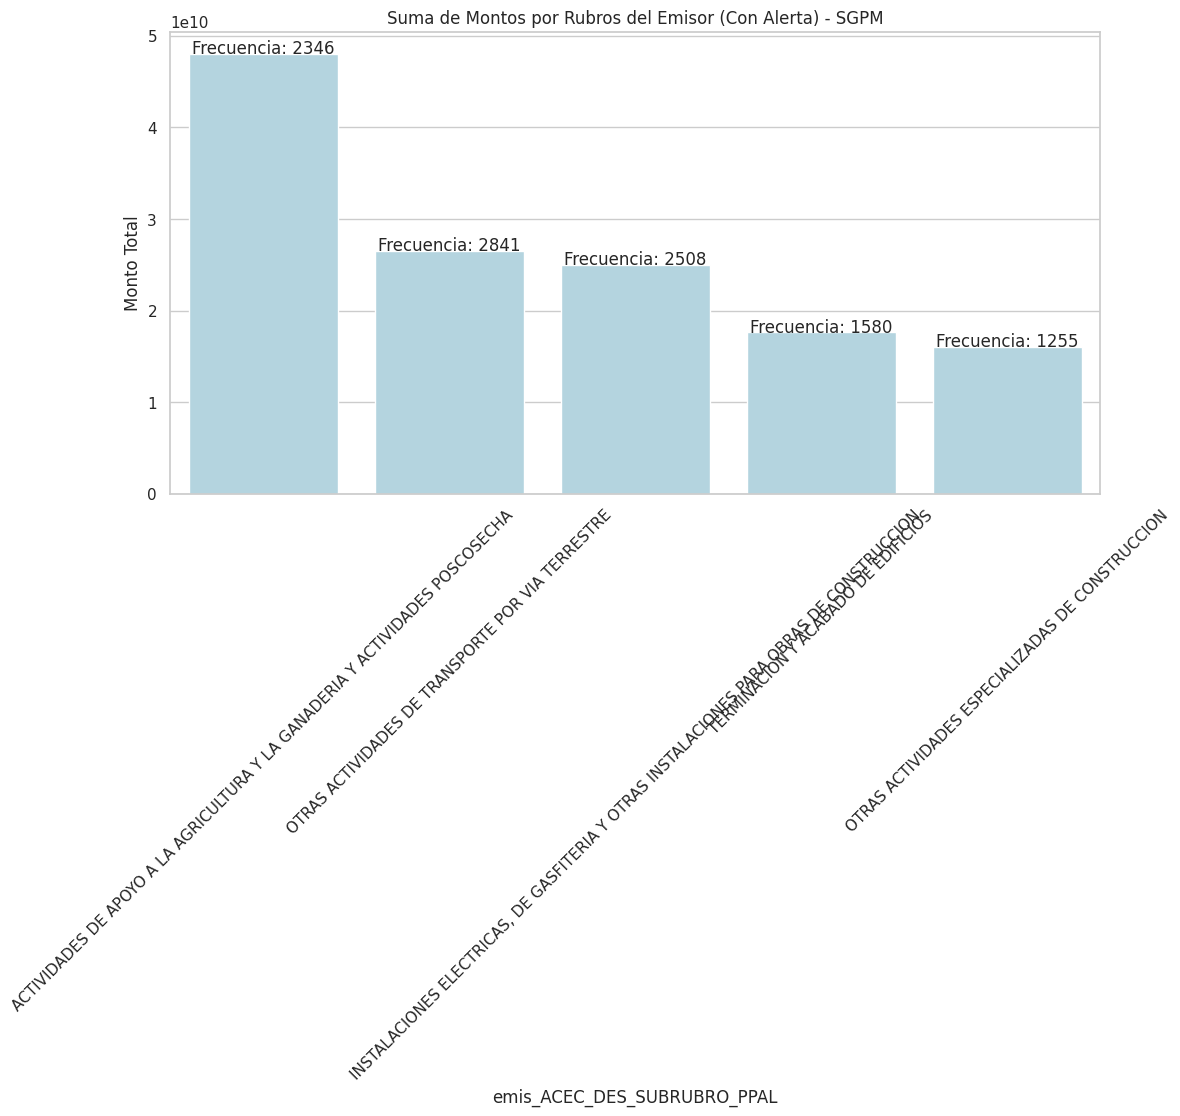

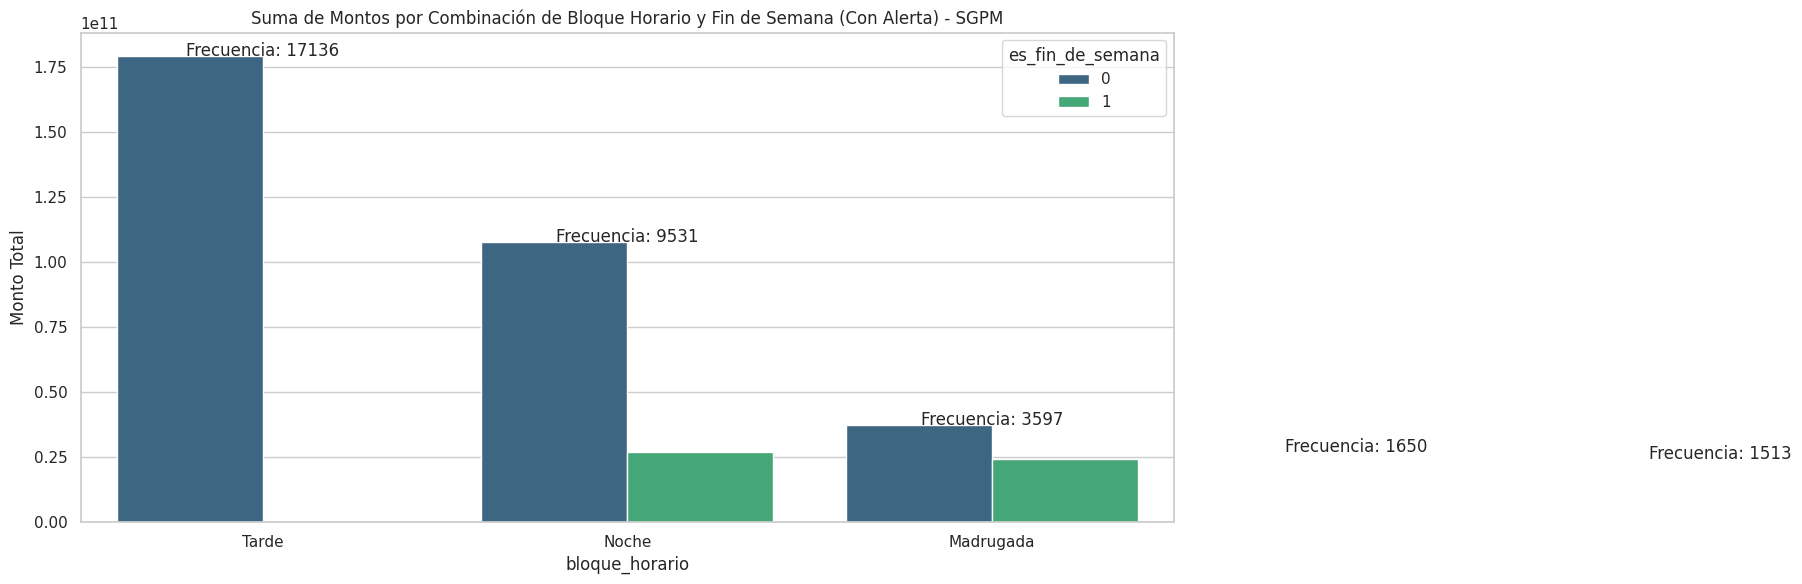

/tmp/ipykernel_779/445903056.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


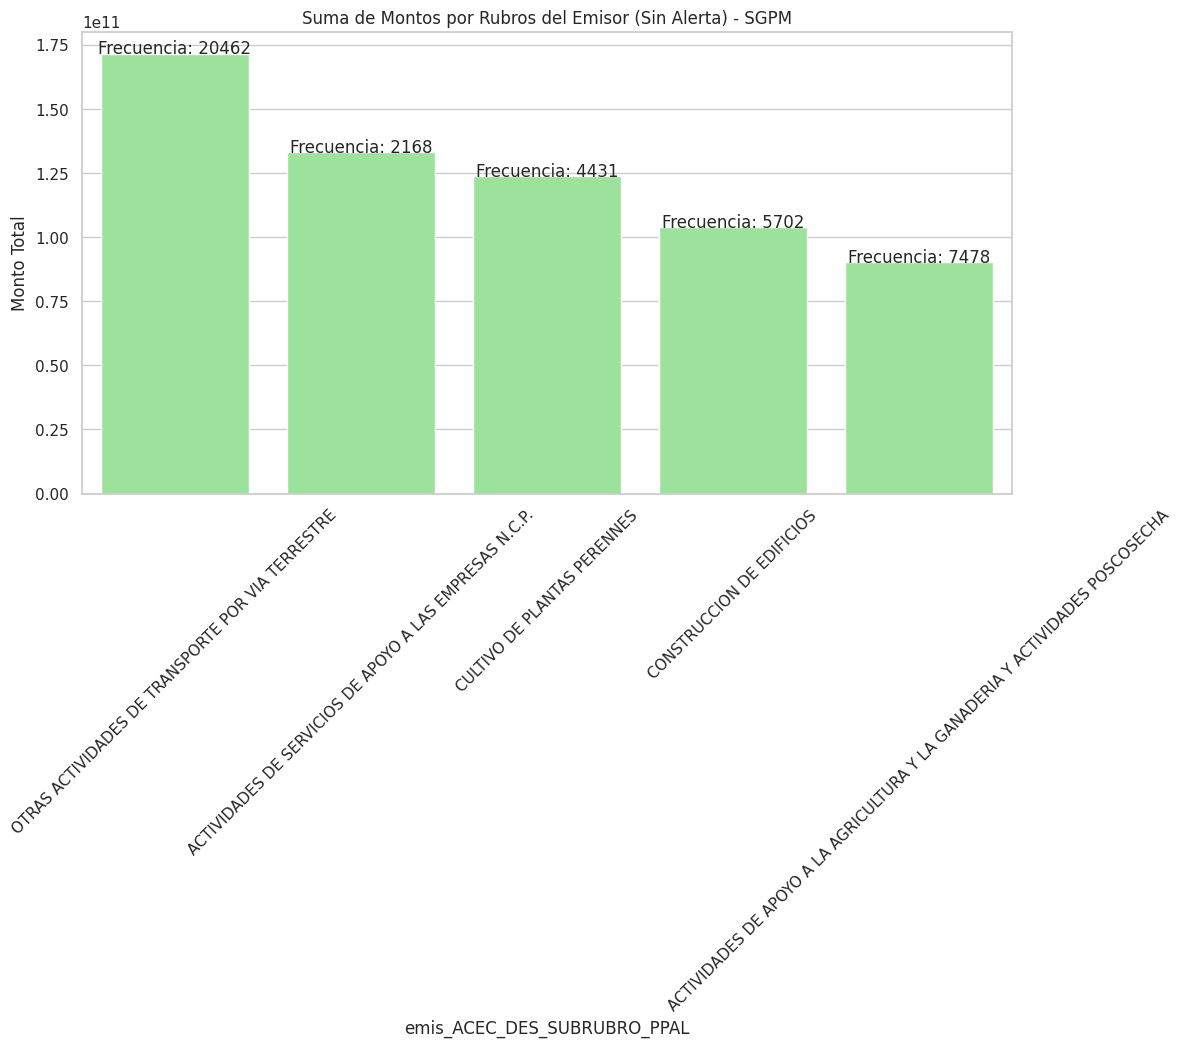

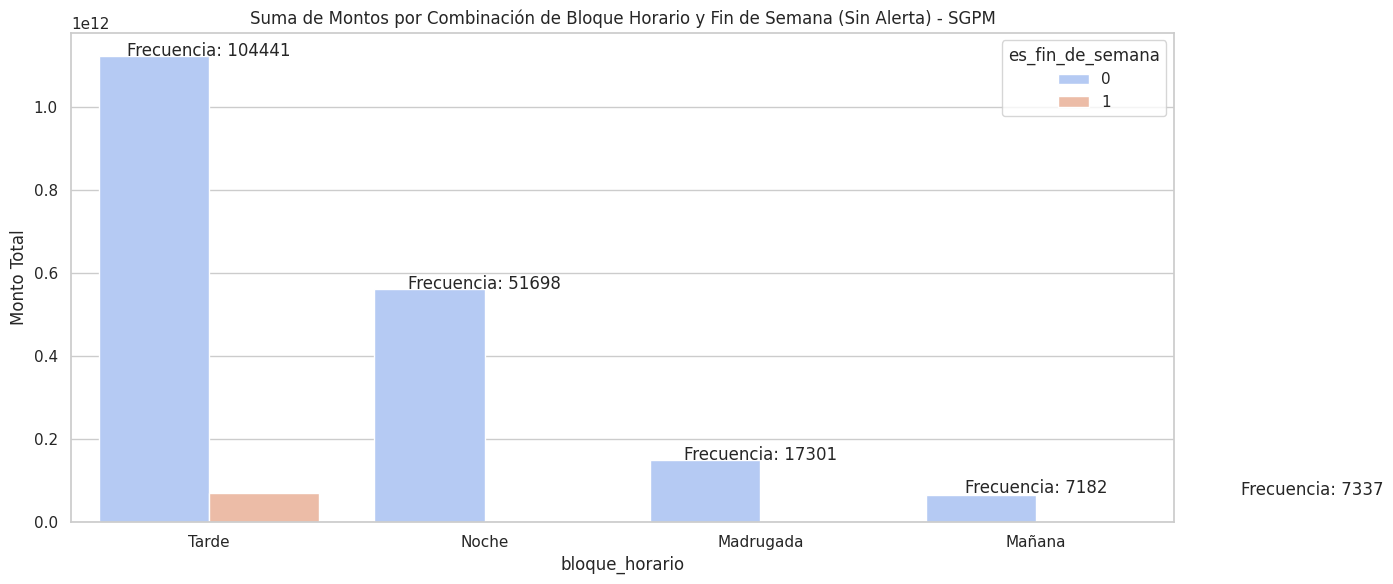

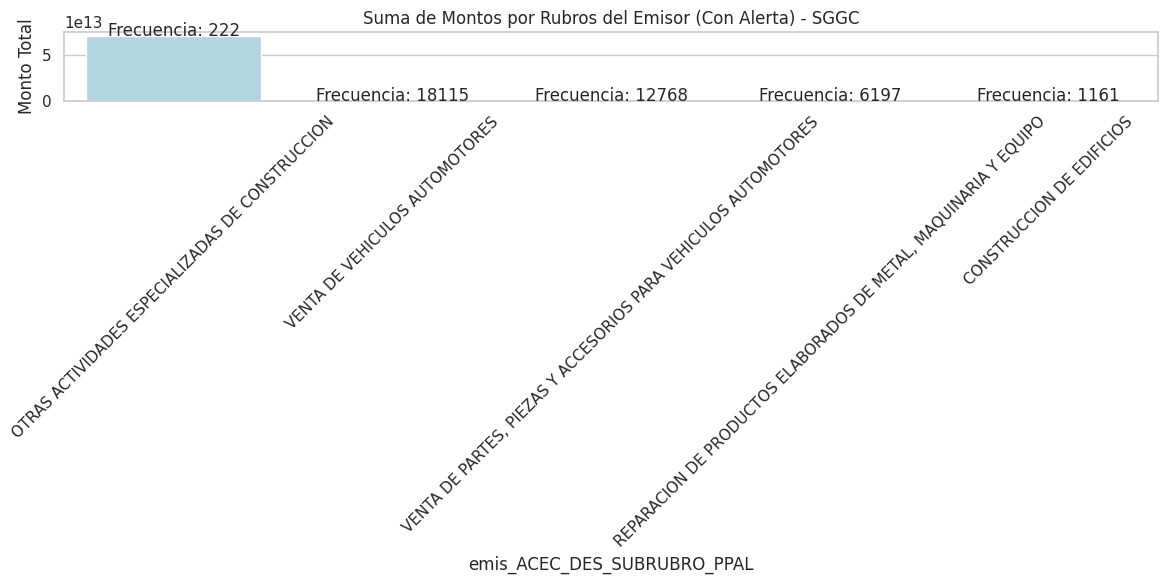

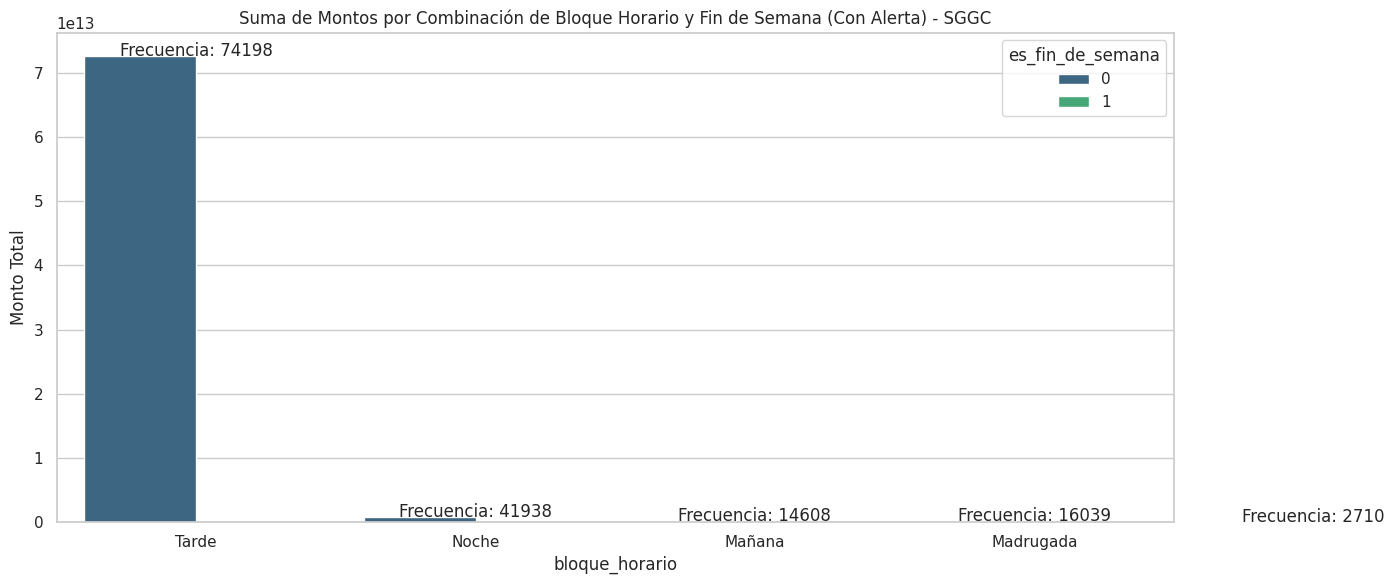

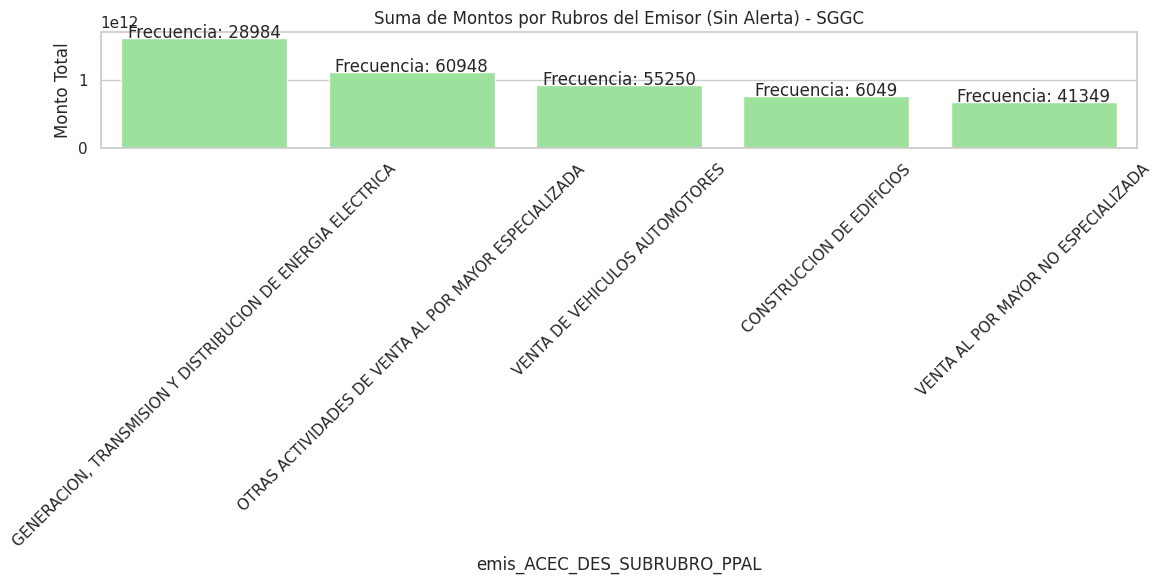

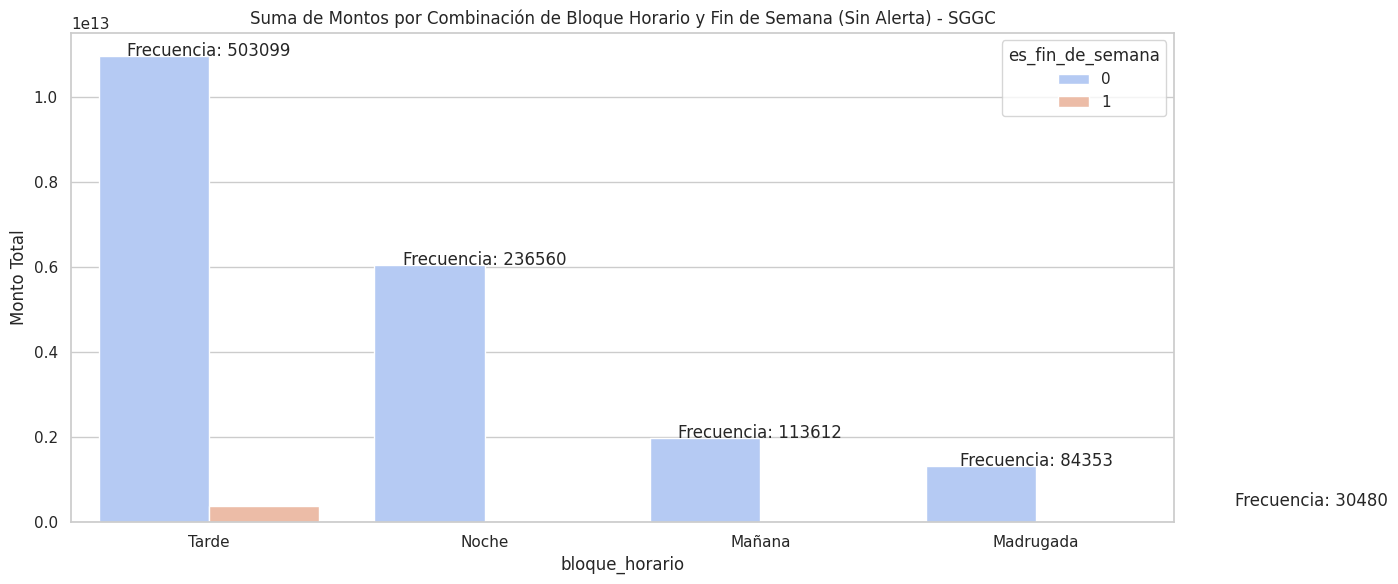

/tmp/ipykernel_779/445903056.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


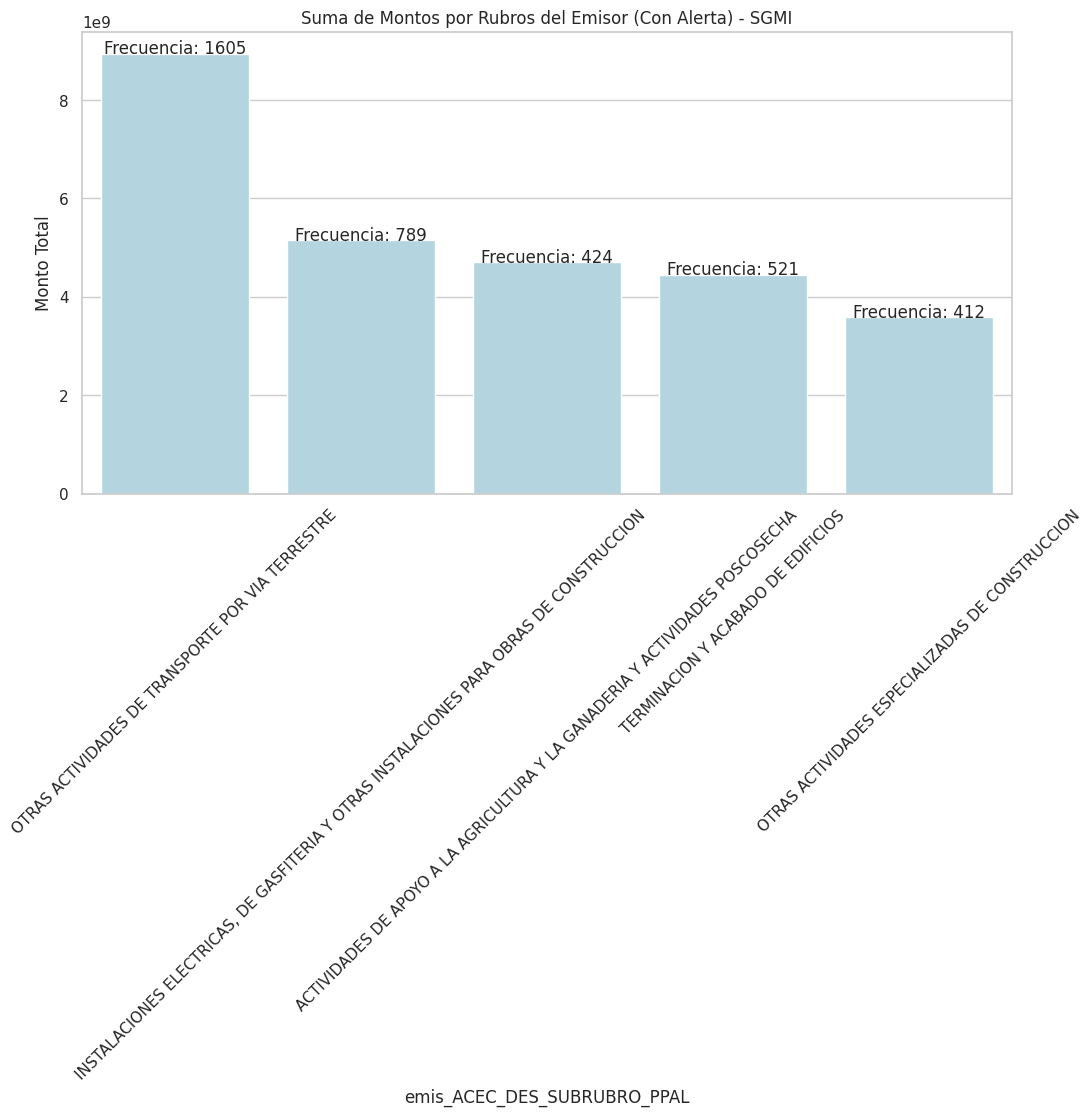

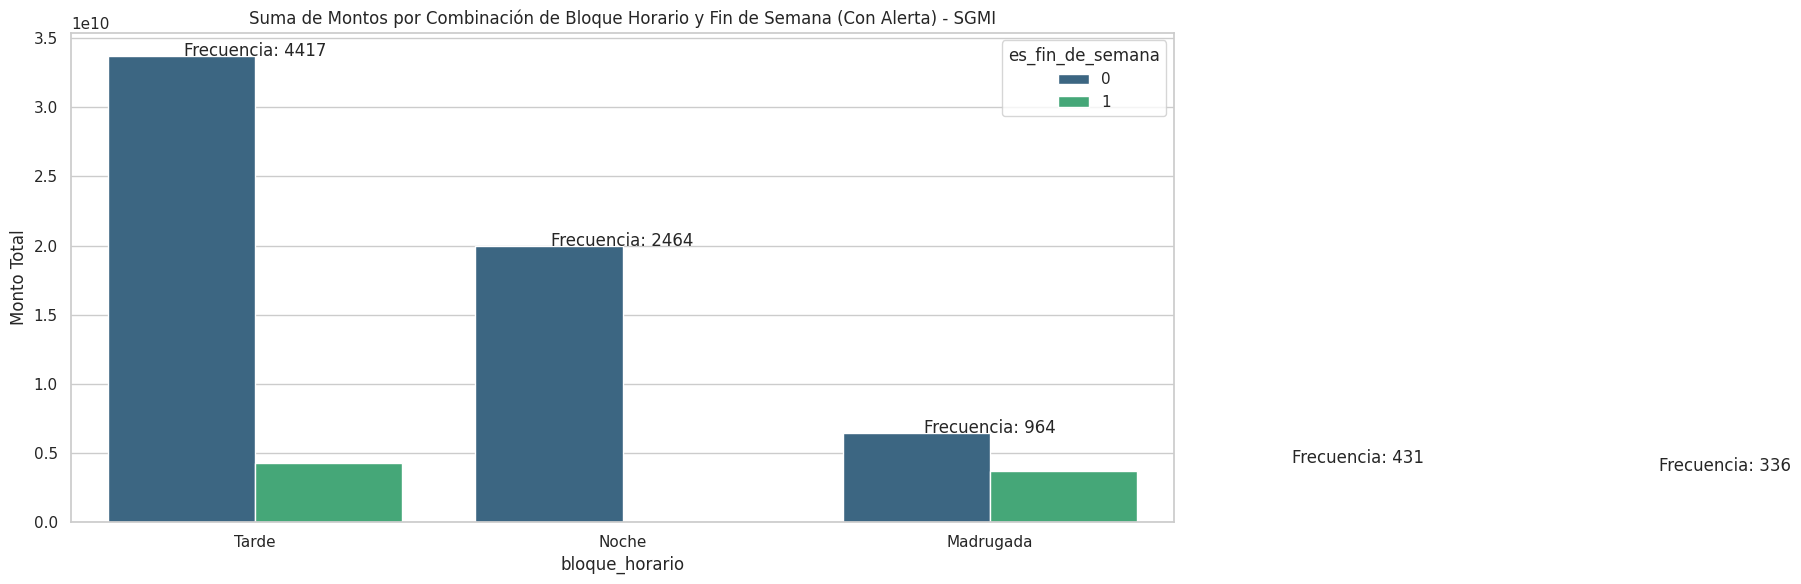

/tmp/ipykernel_779/445903056.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


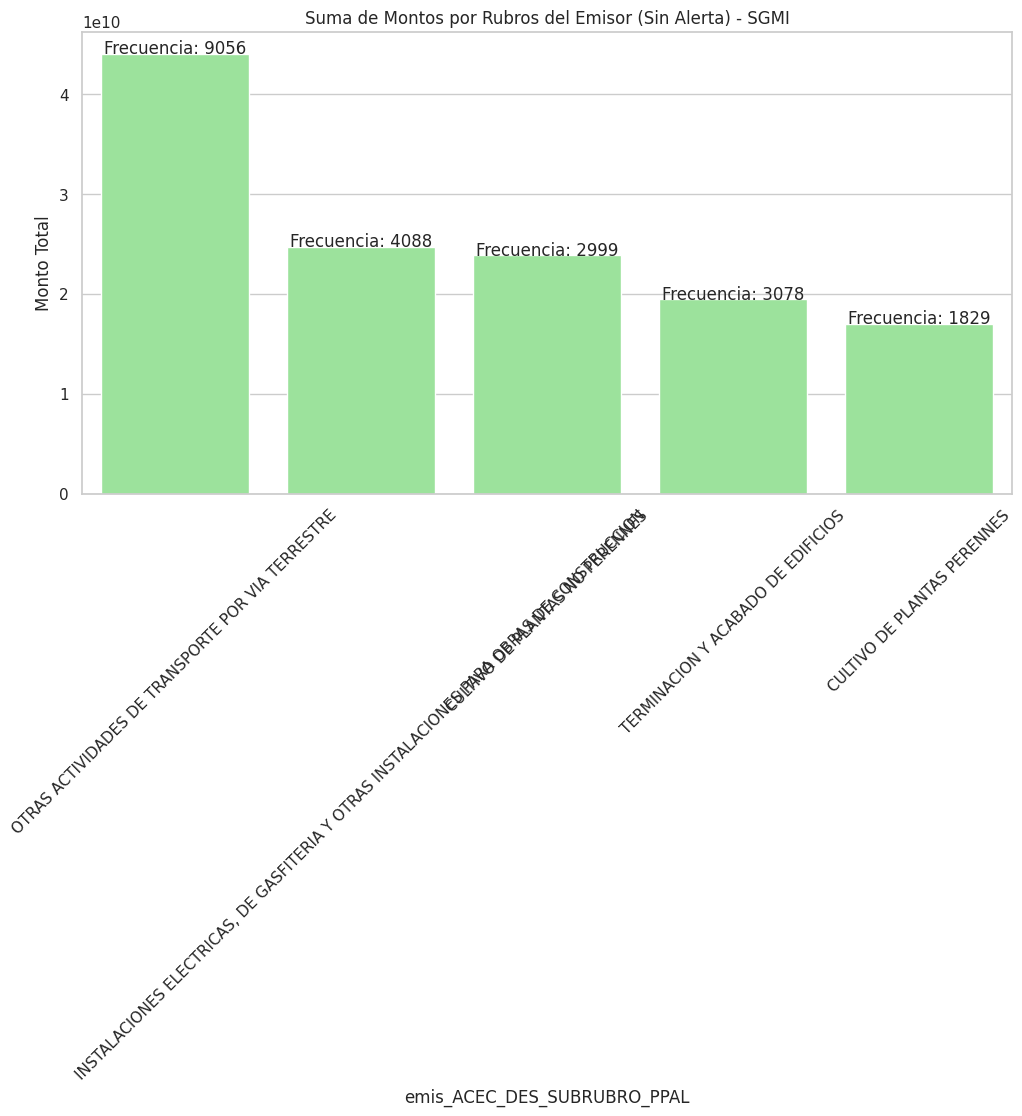

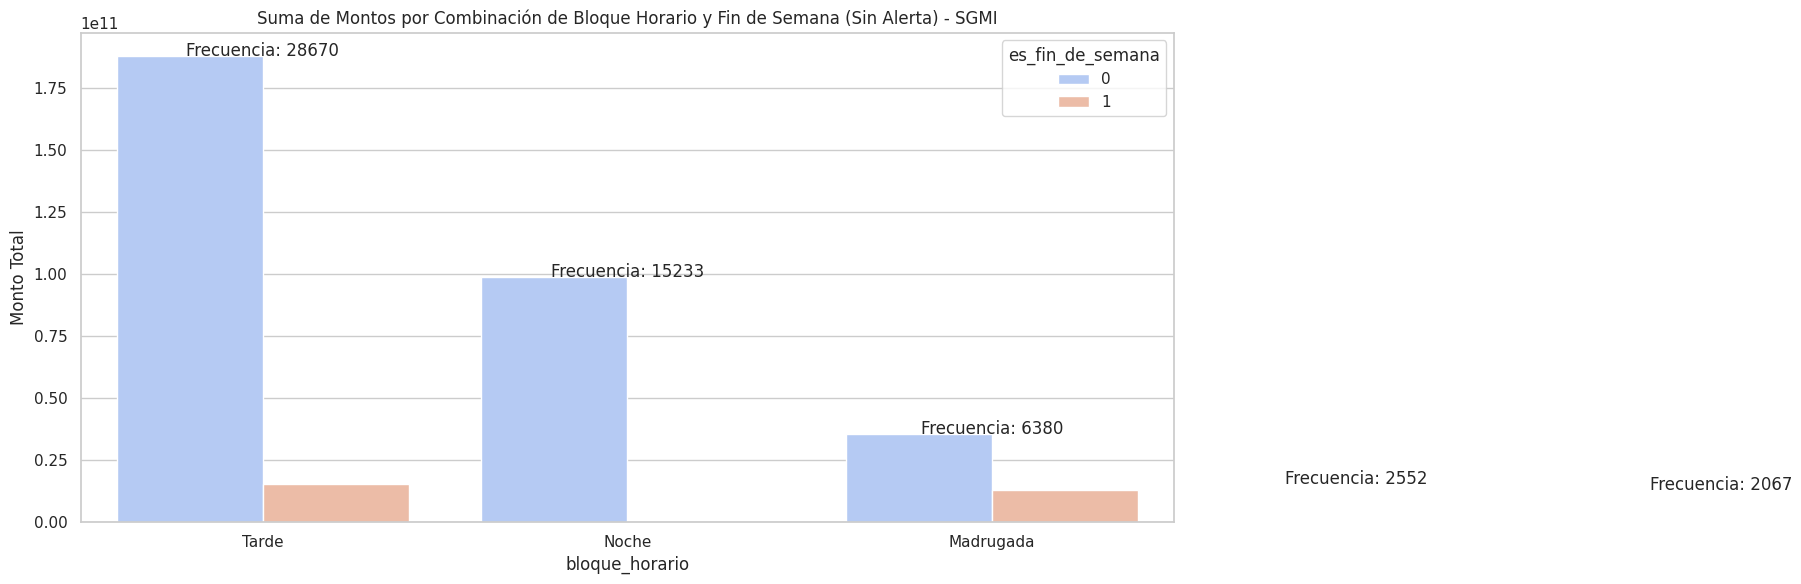

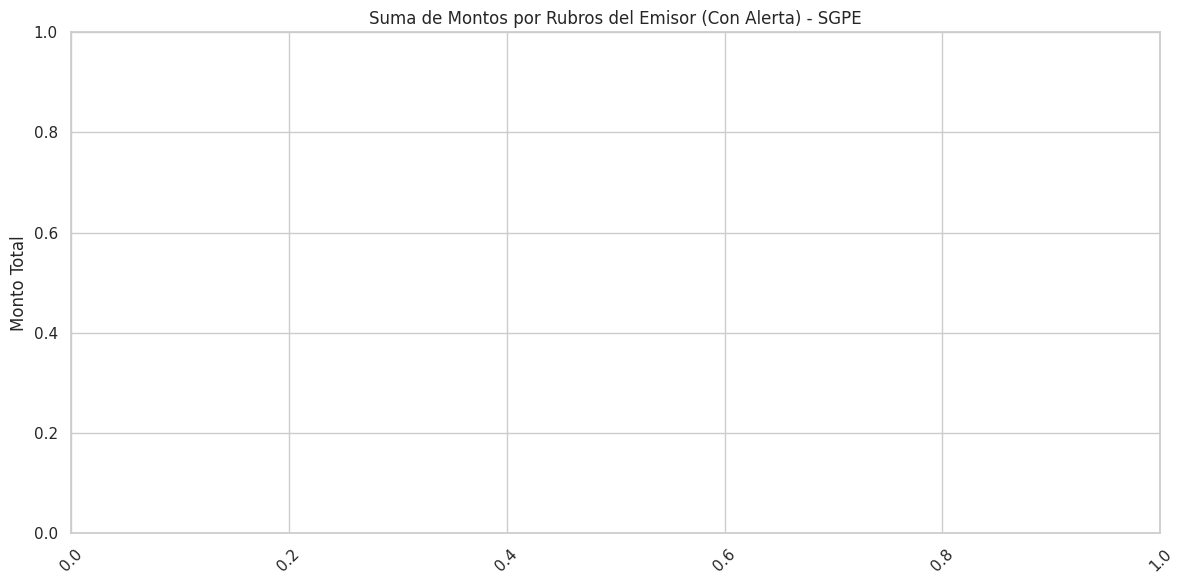

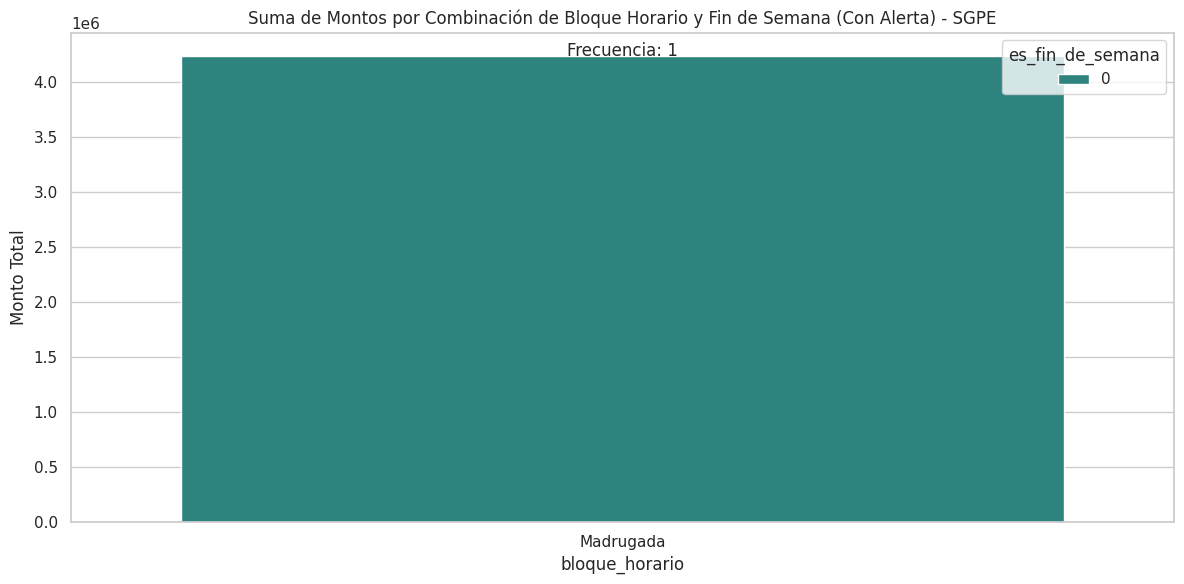

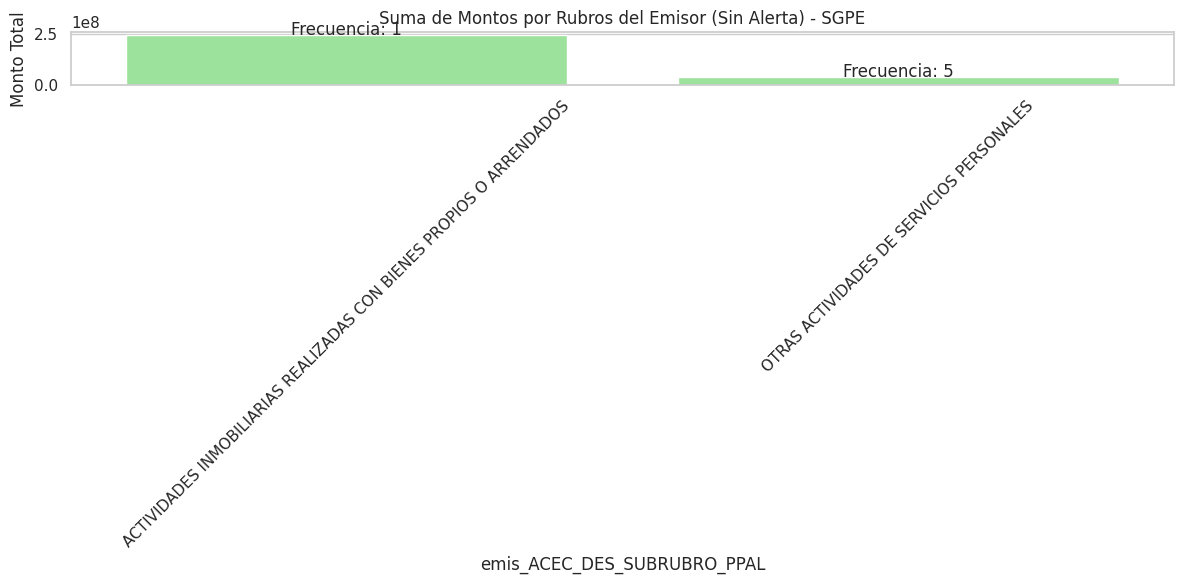

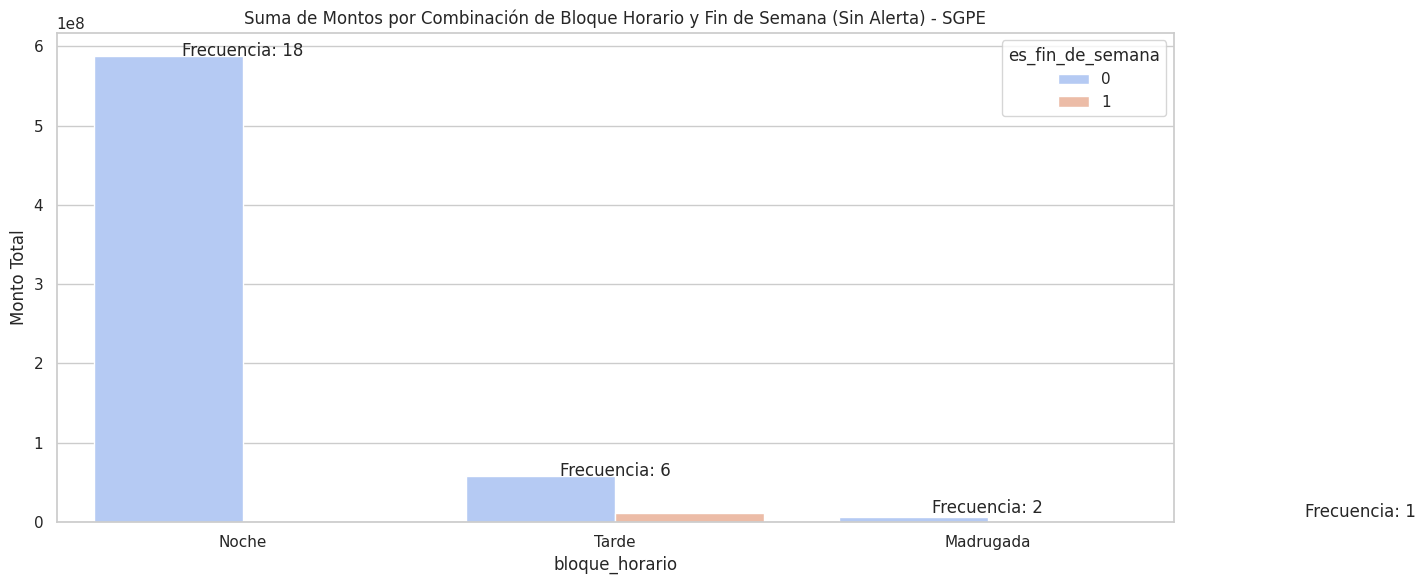

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear los gráficos para cada segmento
for segmento in ['SGME', 'SGPM', 'SGGC', 'SGMI', 'SGPE']:
    # Obtener los outliers con y sin alerta para el segmento
    outliers_alertas = alertas_por_segmento[segmento]
    outliers_sin_alerta = sin_alerta_por_segmento[segmento]
    
    # 1. Gráfico para los rubros del emisor más frecuentes (con alerta)
    # Agrupamos por 'emis_ACEC_DES_SUBRUBRO_PPAL' y calculamos la suma del monto y la cuenta
    rubros_alertas = outliers_alertas.groupby('emis_ACEC_DES_SUBRUBRO_PPAL').agg(
        count=('emis_ACEC_DES_SUBRUBRO_PPAL', 'size'),
        total_monto=('dhdr_mnt_total', 'sum')
    ).reset_index()

    # Seleccionamos los 5 rubros con más monto total
    top_5_rubros_alertas = rubros_alertas.nlargest(5, 'total_monto')
    plt.figure(figsize=(12, 6))

    # Crear gráfico para la suma del monto total
    sns.barplot(data=top_5_rubros_alertas, x='emis_ACEC_DES_SUBRUBRO_PPAL', y='total_monto', color='lightblue')
    plt.title(f"Suma de Montos por Rubros del Emisor (Con Alerta) - {segmento}")
    plt.ylabel('Monto Total')
    plt.xticks(rotation=45)

    # Añadir frecuencia como etiquetas sobre las barras
    for i, row in enumerate(top_5_rubros_alertas.iterrows()):
        plt.text(i, row[1]['total_monto'] + 1000, f"Frecuencia: {row[1]['count']}", ha='center')

    plt.tight_layout()
    plt.show()

    # 2. Gráfico para la combinación de bloque horario y fin de semana (con alerta)
    # Agrupamos por 'bloque_horario' y 'es_fin_de_semana' y calculamos la suma del monto total y la cuenta
    bloque_horario_alertas = outliers_alertas.groupby(['bloque_horario', 'es_fin_de_semana']).agg(
        count=('bloque_horario', 'size'),
        total_monto=('dhdr_mnt_total', 'sum')
    ).reset_index()

    # Seleccionamos las 5 combinaciones con más monto total
    top_5_bloque_horario_alertas = bloque_horario_alertas.nlargest(5, 'total_monto')
    plt.figure(figsize=(12, 6))

    # Crear gráfico para la suma del monto total
    sns.barplot(data=top_5_bloque_horario_alertas, x='bloque_horario', y='total_monto', hue='es_fin_de_semana', palette='viridis')
    plt.title(f"Suma de Montos por Combinación de Bloque Horario y Fin de Semana (Con Alerta) - {segmento}")
    plt.ylabel('Monto Total')
    plt.tight_layout()

    # Añadir frecuencia como etiquetas sobre las barras
    for i, row in enumerate(top_5_bloque_horario_alertas.iterrows()):
        plt.text(i, row[1]['total_monto'] + 1000, f"Frecuencia: {row[1]['count']}", ha='center')

    plt.show()

    # Repetimos para los emisores sin alerta
    # 1. Gráfico para los rubros del emisor más frecuentes (sin alerta)
    rubros_sin_alerta = outliers_sin_alerta.groupby('emis_ACEC_DES_SUBRUBRO_PPAL').agg(
        count=('emis_ACEC_DES_SUBRUBRO_PPAL', 'size'),
        total_monto=('dhdr_mnt_total', 'sum')
    ).reset_index()

    top_5_rubros_sin_alerta = rubros_sin_alerta.nlargest(5, 'total_monto')
    plt.figure(figsize=(12, 6))

    # Crear gráfico para la suma del monto total
    sns.barplot(data=top_5_rubros_sin_alerta, x='emis_ACEC_DES_SUBRUBRO_PPAL', y='total_monto', color='lightgreen')
    plt.title(f"Suma de Montos por Rubros del Emisor (Sin Alerta) - {segmento}")
    plt.ylabel('Monto Total')
    plt.xticks(rotation=45)

    # Añadir frecuencia como etiquetas sobre las barras
    for i, row in enumerate(top_5_rubros_sin_alerta.iterrows()):
        plt.text(i, row[1]['total_monto'] + 1000, f"Frecuencia: {row[1]['count']}", ha='center')

    plt.tight_layout()
    plt.show()

    # 2. Gráfico para la combinación de bloque horario y fin de semana (sin alerta)
    bloque_horario_sin_alerta = outliers_sin_alerta.groupby(['bloque_horario', 'es_fin_de_semana']).agg(
        count=('bloque_horario', 'size'),
        total_monto=('dhdr_mnt_total', 'sum')
    ).reset_index()

    top_5_bloque_horario_sin_alerta = bloque_horario_sin_alerta.nlargest(5, 'total_monto')
    plt.figure(figsize=(12, 6))

    # Crear gráfico para la suma del monto total
    sns.barplot(data=top_5_bloque_horario_sin_alerta, x='bloque_horario', y='total_monto', hue='es_fin_de_semana', palette='coolwarm')
    plt.title(f"Suma de Montos por Combinación de Bloque Horario y Fin de Semana (Sin Alerta) - {segmento}")
    plt.ylabel('Monto Total')
    plt.tight_layout()

    # Añadir frecuencia como etiquetas sobre las barras
    for i, row in enumerate(top_5_bloque_horario_sin_alerta.iterrows()):
        plt.text(i, row[1]['total_monto'] + 1000, f"Frecuencia: {row[1]['count']}", ha='center')

    plt.show()


###  Observaciones: el analisis exploratorio de datos es introductorio y requiere ser complementado con una comprension profunda de la naturaleza de las transacciones de tipo 33. 
### En este dataset solo se han utilizados variables de tipo tiempo, variables generales de los contribuyentes (emisor y receptor) e informacion agregada del monto e iva de los contribuyentes en esta ventana de tiempo. Para incluir mas variables, revisar el proceso de obtencion del dataset. 

In [ ]:
Segmento: SGME
Percentil 90 (Monto): 1170000.0
Tamaño de los Outliers: 220531
----------------------------------------
Segmento: SGPM
Percentil 90 (Monto): 1760010.0
Tamaño de los Outliers: 235336
----------------------------------------
Segmento: SGGC
Percentil 90 (Monto): 1104695.4000000004
Tamaño de los Outliers: 1164345
----------------------------------------
Segmento: SGMI
Percentil 90 (Monto): 2070600.0
Tamaño de los Outliers: 68017
----------------------------------------
Segmento: SGPE
Percentil 90 (Monto): 3913102.000000001
Tamaño de los Outliers: 28
----------------------------------------
